#**Packages**

In [ ]:
from datetime import datetime
import numpy as np   
import pandas as pd 
import matplotlib.pylab as plt 
import seaborn as sns
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
rcParams['figure.figsize'] = 22, 10

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip uninstall pmdarima -y
!pip install pmdarima

Found existing installation: pmdarima 2.0.1
Uninstalling pmdarima-2.0.1:
  Successfully uninstalled pmdarima-2.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pmdarima-2.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.8 MB)


In [ ]:
import statsmodels.compat.numpy
from pmdarima import auto_arima

#Read Data

In [ ]:
dataset = pd.read_csv("city_day.csv", parse_dates = True)
#Parse strings to datetime type
dataset['Date'] = pd.to_datetime(dataset['Date'],infer_datetime_format=True) #convert from string to datetime
dataset

City       Date  PM2.5   PM10     NO    NO2    NOx    NH3  \
0          Ahmedabad 2015-01-01    NaN    NaN   0.92  18.22  17.15    NaN   
1          Ahmedabad 2015-01-02    NaN    NaN   0.97  15.69  16.46    NaN   
2          Ahmedabad 2015-01-03    NaN    NaN  17.40  19.30  29.70    NaN   
3          Ahmedabad 2015-01-04    NaN    NaN   1.70  18.48  17.97    NaN   
4          Ahmedabad 2015-01-05    NaN    NaN  22.10  21.42  37.76    NaN   
...              ...        ...    ...    ...    ...    ...    ...    ...   
29526  Visakhapatnam 2020-06-27  15.02  50.94   7.68  25.06  19.54  12.47   
29527  Visakhapatnam 2020-06-28  24.38  74.09   3.42  26.06  16.53  11.99   
29528  Visakhapatnam 2020-06-29  22.91  65.73   3.45  29.53  18.33  10.71   
29529  Visakhapatnam 2020-06-30  16.64  49.97   4.05  29.26  18.80  10.03   
29530  Visakhapatnam 2020-07-01  15.00  66.00   0.40  26.85  14.05   5.20   

          CO    SO2      O3  Benzene  Toluene  Xylene   AQI    AQI_Bucket  
0       0.92  27.64  133.36     0.00     0.02    0.00   NaN           NaN  
1       0.97  24.55   34.06     3.68     5.50    3.77   NaN           NaN  
2      17.40  29.07   30.70     6.80    16.40    2.25   NaN           NaN  
3       1.70  18.59   36.08     4.43    10.14    1.00   NaN           NaN  
4      22.10  39.33   39.31     7.01    18.89    2.78   NaN           NaN  
...      ...    ...     ...      ...      ...     ...   ...           ...  
29526   0.47   8.55   23.30     2.24    12.07    0.73  41.0          Good  
29527   0.52  12.72   30.14     0.74     2.21    0.38  70.0  Satisfactory  
29528   0.48   8.42   30.96     0.01     0.01    0.00  68.0  Satisfactory  
29529   0.52   9.84   28.30     0.00     0.00    0.00  54.0  Satisfactory  
29530   0.59   2.10   17.05      NaN      NaN     NaN  50.0          Good  

[29531 rows x 16 columns]

In [ ]:
AQI_data = dataset[["Date", "AQI", "City"]]
AQI_data = AQI_data.set_index(['Date'])
AQI_data.tail(5)

AQI           City
Date                           
2020-06-27  41.0  Visakhapatnam
2020-06-28  70.0  Visakhapatnam
2020-06-29  68.0  Visakhapatnam
2020-06-30  54.0  Visakhapatnam
2020-07-01  50.0  Visakhapatnam

#**Delhi**

##Data Processing

In [ ]:
AQI_Delhi = AQI_data.loc[AQI_data['City'] == 'Delhi']
AQI_Delhi = AQI_Delhi.drop('City',axis = 1)

AQI_Delhi = AQI_Delhi.replace(' ',np.nan)
AQI_Delhi = AQI_Delhi.dropna() 
AQI_Delhi


AQI
Date             
2015-01-01  472.0
2015-01-02  454.0
2015-01-03  143.0
2015-01-04  319.0
2015-01-05  325.0
...           ...
2020-06-27  112.0
2020-06-28  196.0
2020-06-29  233.0
2020-06-30  114.0
2020-07-01  101.0

[1999 rows x 1 columns]

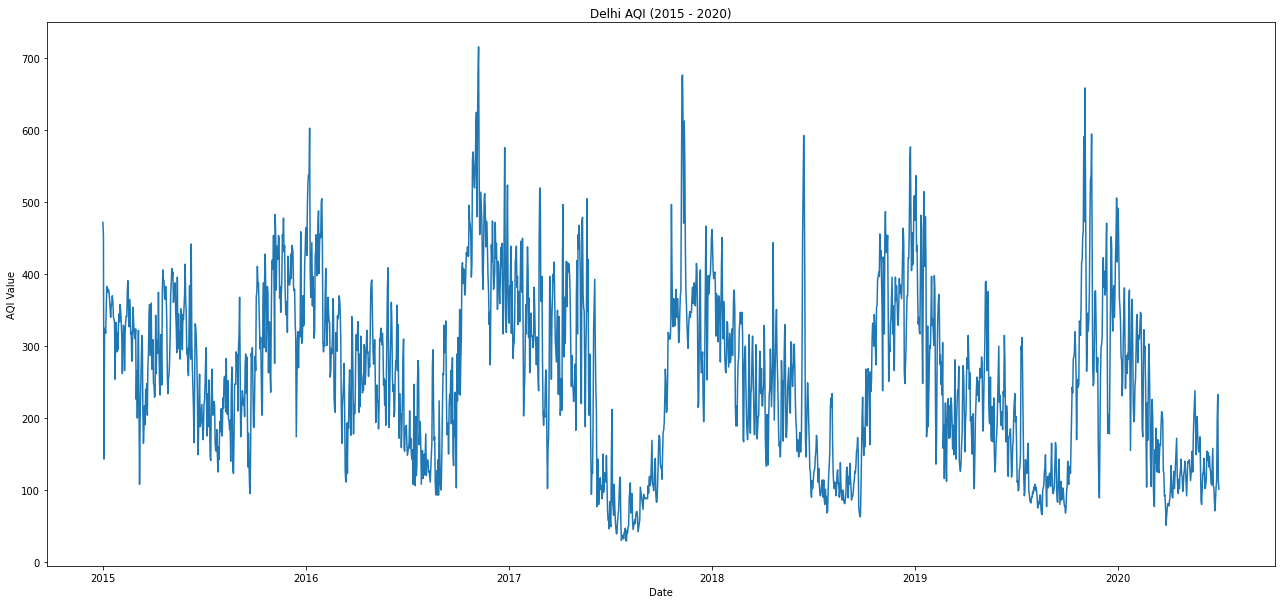

In [ ]:
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.plot(AQI_Delhi)
plt.title("Delhi AQI (2015 - 2020)")
plt.show()

##Stationarity Check

In [ ]:
#Determine rolling statistics
rolmean = AQI_Delhi.rolling(window=7).mean()
rolstd = AQI_Delhi.rolling(window=7).std()
print(rolmean,rolstd)

                   AQI
Date                  
2015-01-01         NaN
2015-01-02         NaN
2015-01-03         NaN
2015-01-04         NaN
2015-01-05         NaN
...                ...
2020-06-27   95.285714
2020-06-28  108.285714
2020-06-29  126.714286
2020-06-30  130.857143
2020-07-01  135.142857

[1999 rows x 1 columns]                   AQI
Date                 
2015-01-01        NaN
2015-01-02        NaN
2015-01-03        NaN
2015-01-04        NaN
2015-01-05        NaN
...               ...
2020-06-27  14.761598
2020-06-28  41.177317
2020-06-29  62.358411
2020-06-30  60.045618
2020-07-01  55.995323

[1999 rows x 1 columns]


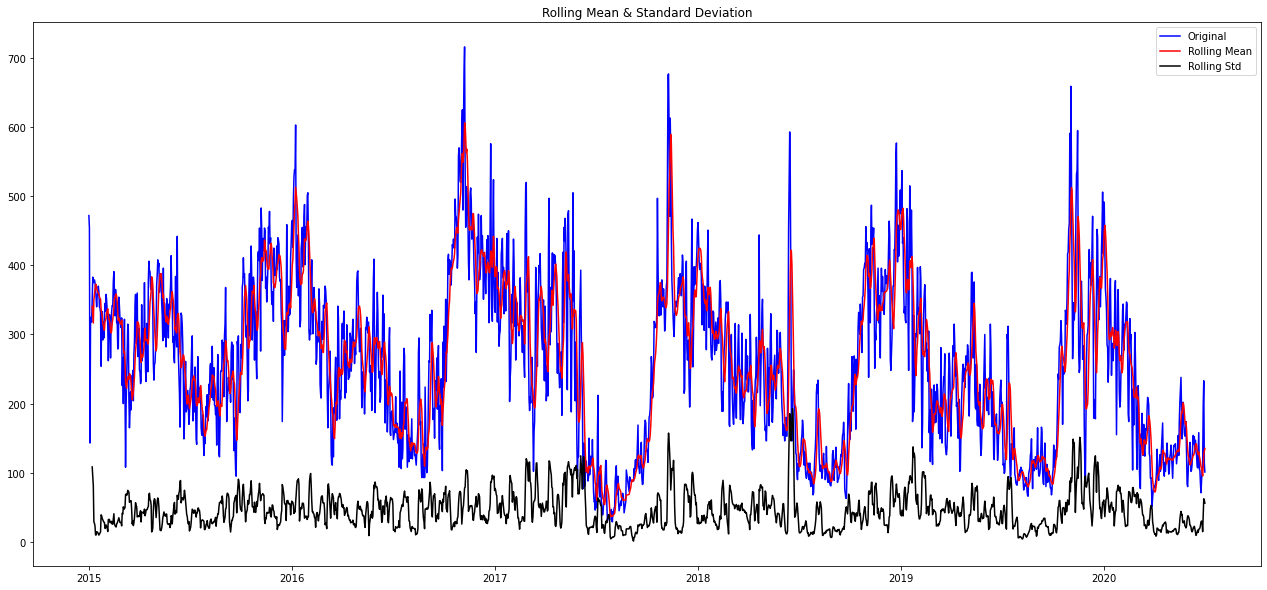

In [ ]:
orig = plt.plot(AQI_Delhi, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(AQI_Delhi['AQI'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -3.458734
p-value                           0.009112
#Lags Used                       17.000000
Number of Observations Used    1981.000000
Critical Value (1%)              -3.433655
Critical Value (5%)              -2.863000
Critical Value (10%)             -2.567547
dtype: float64


##ETS Decomposition

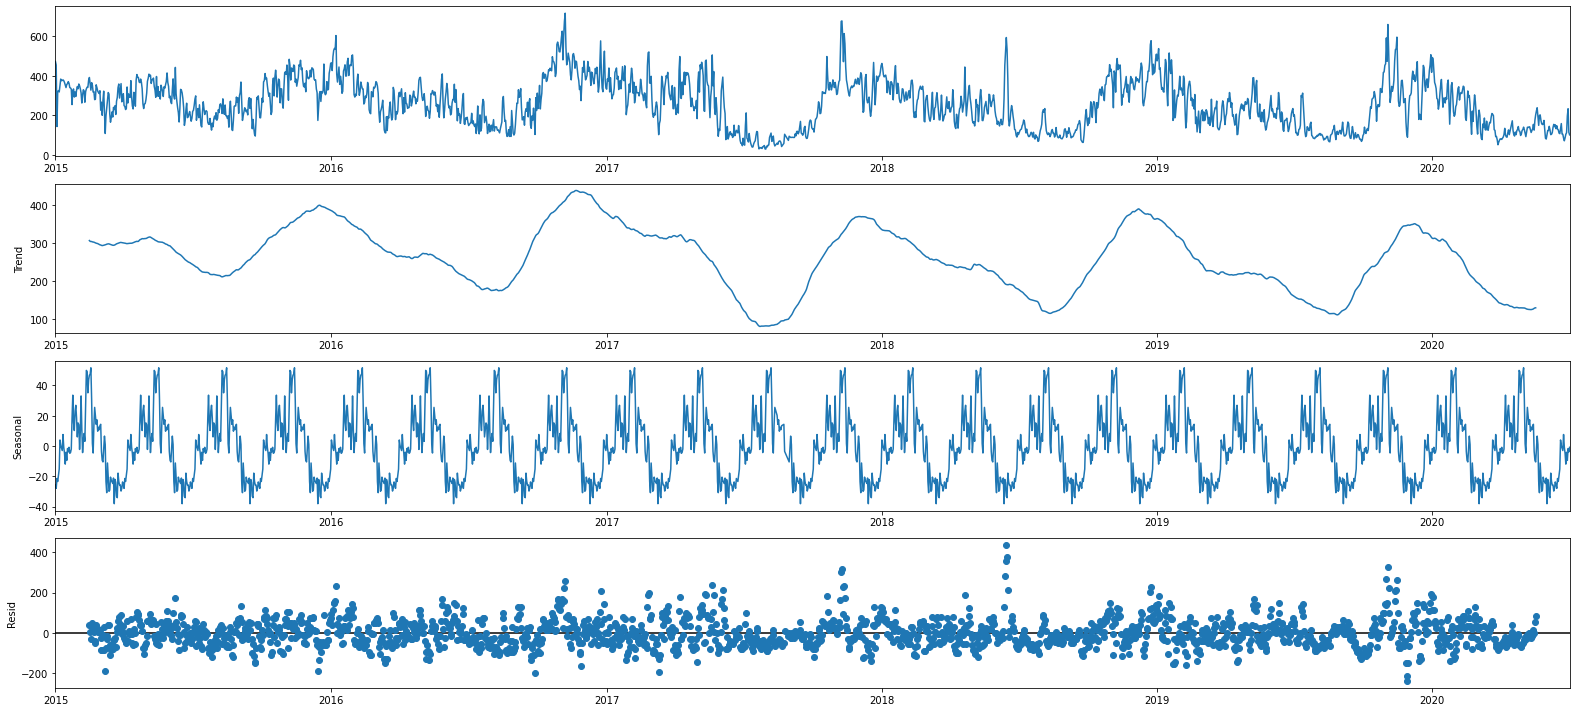

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(AQI_Delhi, period = 90)
result.plot()
plt.show()

##Model

In [ ]:
stepwise_fit = auto_arima(AQI_Delhi['AQI'], m = 7,
                          seasonal = True,
                          trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True) 


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=21305.534, Time=5.16 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=21533.751, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=21536.373, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=21535.589, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=21531.776, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=21304.876, Time=3.03 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=21303.292, Time=1.25 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=21304.859, Time=2.62 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=21301.309, Time=0.97 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=21302.889, Time=1.65 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=21302.906, Time=2.01 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=21303.606, Time=4.23 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=21382.342, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=21356.541, Time=0.57 sec
 ARIMA(1,1,3)(0,0,0

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                 1999
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -10645.719
Date:                Fri, 07 Oct 2022   AIC                          21299.439
Time:                        18:34:48   BIC                          21321.838
Sample:                             0   HQIC                         21307.664
                               - 1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4915      0.036     13.484      0.000       0.420       0.563
ma.L1         -0.6062      0.038    -16.110      0.000      -0.680      -0.532
ma.L2         -0.2386      0.023    -10.377      0.0

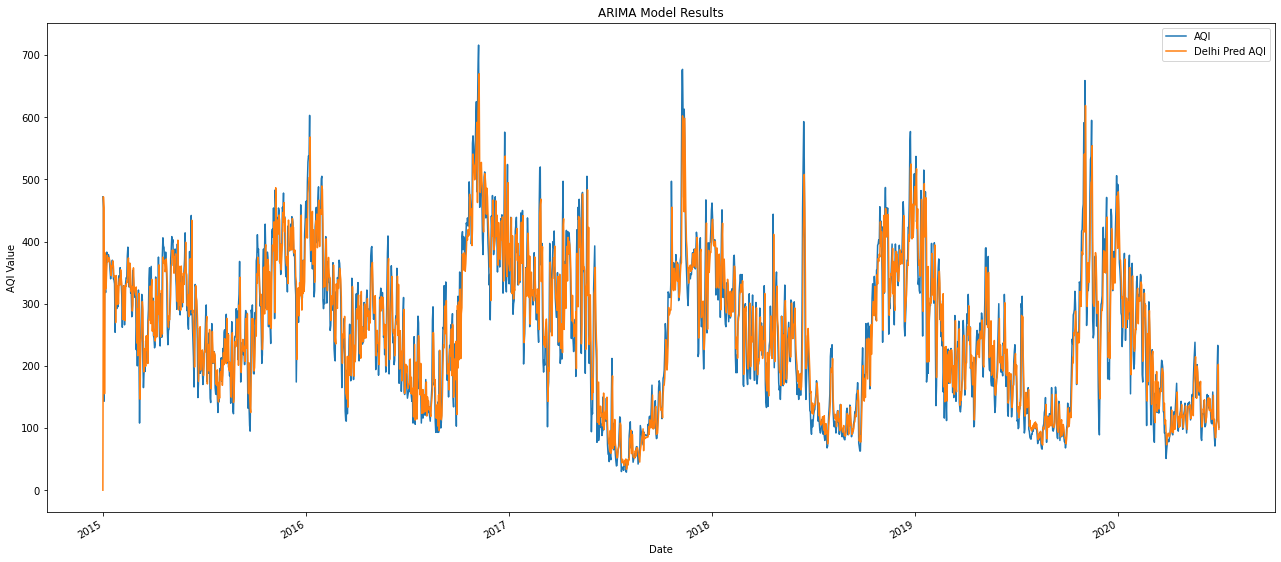

In [ ]:
Delhi_model = ARIMA(AQI_Delhi, order=(1,1,2))
results_ARIMA = Delhi_model.fit()
print(results_ARIMA.summary())
Delhi_Model_AQI = results_ARIMA.fittedvalues.rename('Delhi Pred AQI')

AQI_Delhi.plot(legend=True)
plt.xlabel('Date')
plt.ylabel('AQI Value')
Delhi_Model_AQI.plot(legend=True)
plt.title('ARIMA Model Results')
plt.show()

##Test Sample Evaluation

In [ ]:
Delhi_training = AQI_Delhi.iloc[:1451]
Delhi_test = AQI_Delhi.iloc[1452:]
print(Delhi_training.shape, Delhi_test.shape)

(1451, 1) (547, 1)


In [ ]:
train_model = ARIMA(Delhi_training, order=(1,1,1))
train_ARIMA = train_model.fit()

In [ ]:
start = len(Delhi_training)
end = len(Delhi_training)+len(Delhi_test)-1
pred = results_ARIMA.predict(start=start, end=end, typ='levels')
pred.index=AQI_Delhi.index[start:end+1]
pred=pred.rename("Pred AQI")
print(pred)

Date
2019-01-01    488.423766
2019-01-02    458.890206
2019-01-03    491.455571
2019-01-04    517.039539
2019-01-05    421.077979
                 ...    
2020-06-26     97.565956
2020-06-27    108.541944
2020-06-28    112.300592
2020-06-29    185.723105
2020-06-30    202.558771
Name: Pred AQI, Length: 547, dtype: float64


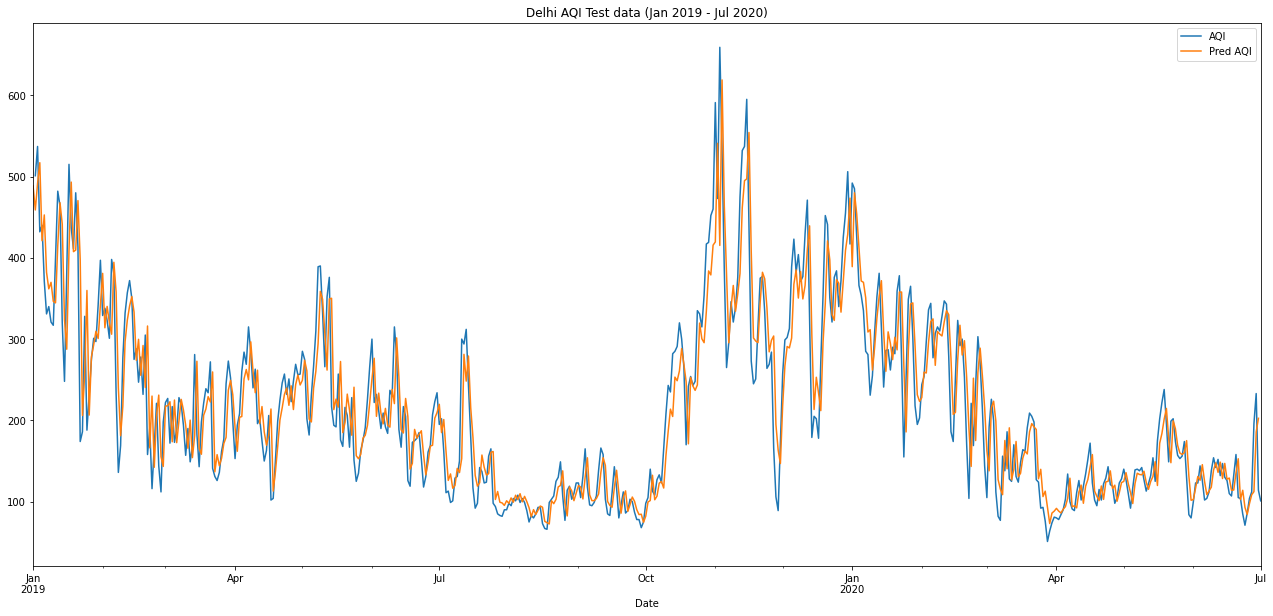

In [ ]:
Delhi_test['AQI'].plot(legend=True)
pred.plot(legend=True)
plt.title('Delhi AQI Test data (Jan 2019 - Jul 2020)')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
Delhi_corr = np.corrcoef(pred, Delhi_test.squeeze())[0,1]
Delhi_MAPE = mean_absolute_percentage_error(Delhi_test.squeeze(),pred)
print("Correlation Coefficient: {}".format(Delhi_corr))
print("Mean Absolute Percentage Error: {}".format(Delhi_MAPE))

Correlation Coefficient: 0.8102139096278757
Mean Absolute Percentage Error: 0.25249405793833


##AQI future trend prediction for next 1 - Year. 

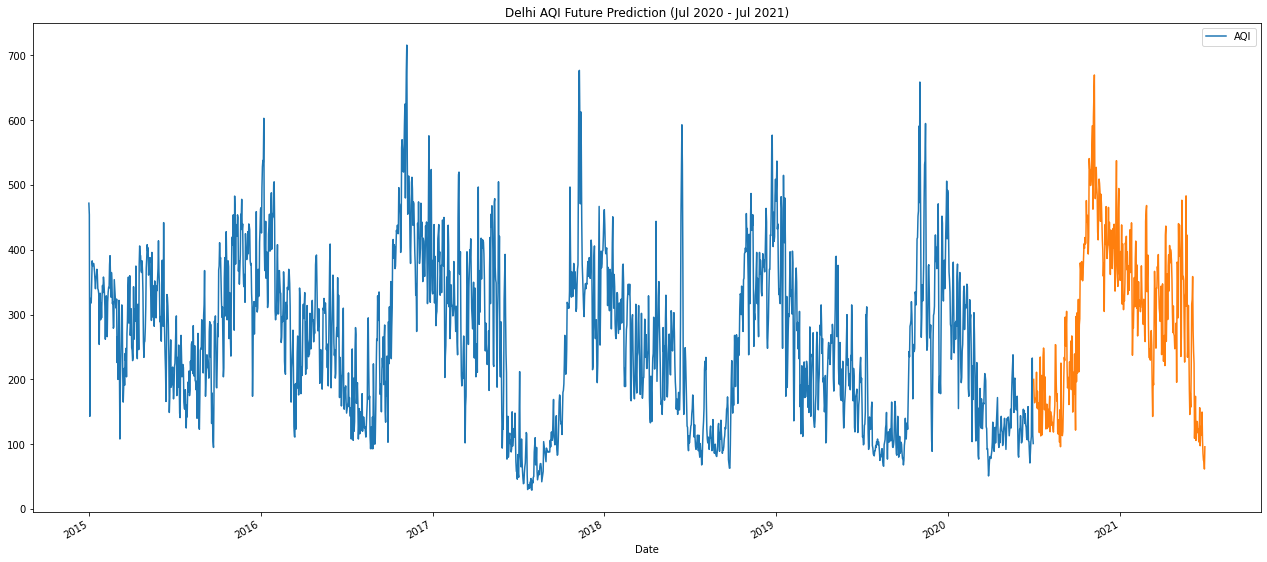

In [ ]:
index_future = pd.date_range(start='2020-07-02', end='2021-07-01')
pred_2 = results_ARIMA.predict(start=len(Delhi_test),end = len(Delhi_test)+364, typ = 'levels')
pred_2.index = index_future
AQI_Delhi.plot()
pred_2.plot()
plt.title("Delhi AQI Future Prediction (Jul 2020 - Jul 2021)")
plt.show()

#***Chennai***


##Data Processing

In [ ]:
AQI_chen = AQI_data.loc[AQI_data['City'] == 'Chennai']
AQI_chen = AQI_chen.drop('City',axis = 1)

AQI_chen = AQI_chen.replace(' ',np.nan)
AQI_chen = AQI_chen.dropna() 
AQI_chen

AQI
Date             
2015-03-24  333.0
2015-03-26  318.0
2015-03-27  408.0
2015-03-28  448.0
2015-03-31  312.0
...           ...
2020-06-27   95.0
2020-06-28   98.0
2020-06-29  104.0
2020-06-30  110.0
2020-07-01   92.0

[1884 rows x 1 columns]

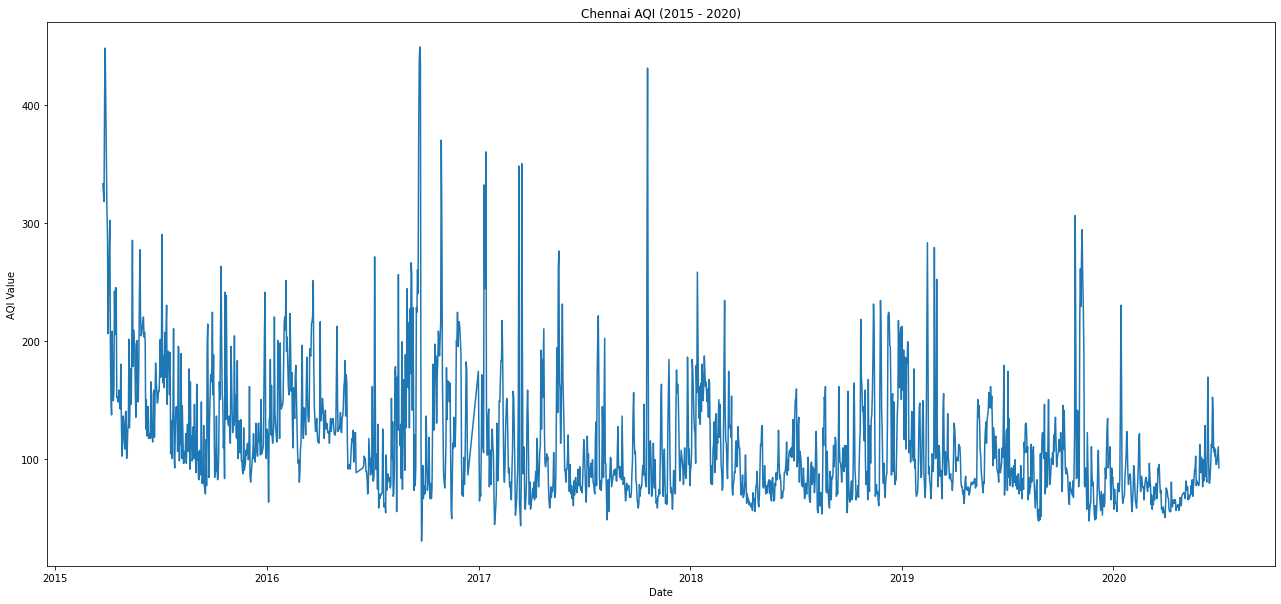

In [ ]:
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.plot(AQI_chen)
plt.title("Chennai AQI (2015 - 2020)")
plt.show()

##Stationarity Check

In [ ]:
#Determine rolling statistics
rolmean = AQI_chen.rolling(window=7).mean() 
rolstd = AQI_chen.rolling(window=7).std()
print(rolmean,rolstd)

                   AQI
Date                  
2015-03-24         NaN
2015-03-26         NaN
2015-03-27         NaN
2015-03-28         NaN
2015-03-31         NaN
...                ...
2020-06-27  107.857143
2020-06-28  101.857143
2020-06-29  101.571429
2020-06-30  101.714286
2020-07-01  100.285714

[1884 rows x 1 columns]                   AQI
Date                 
2015-03-24        NaN
2015-03-26        NaN
2015-03-27        NaN
2015-03-28        NaN
2015-03-31        NaN
...               ...
2020-06-27  15.290831
2020-06-28   5.984106
2020-06-29   5.798193
2020-06-30   6.019809
2020-07-01   7.040698

[1884 rows x 1 columns]


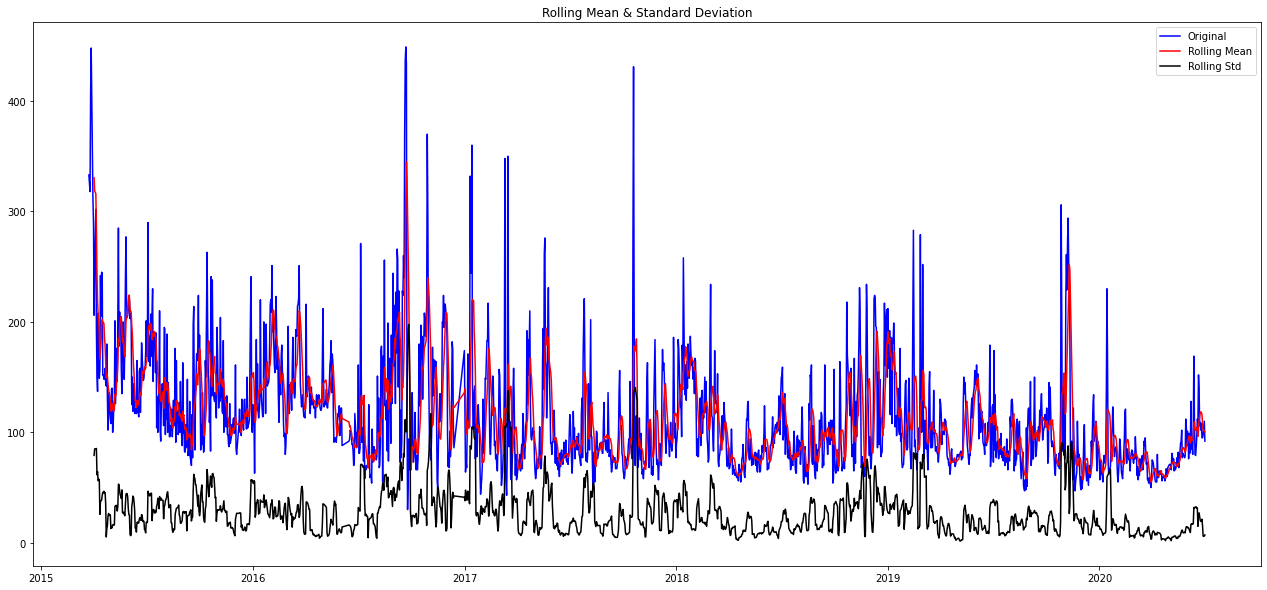

In [ ]:
orig = plt.plot(AQI_chen, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(AQI_chen['AQI'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -6.884056e+00
p-value                        1.409336e-09
#Lags Used                     1.300000e+01
Number of Observations Used    1.870000e+03
Critical Value (1%)           -3.433852e+00
Critical Value (5%)           -2.863087e+00
Critical Value (10%)          -2.567593e+00
dtype: float64


##ETS Decomposition

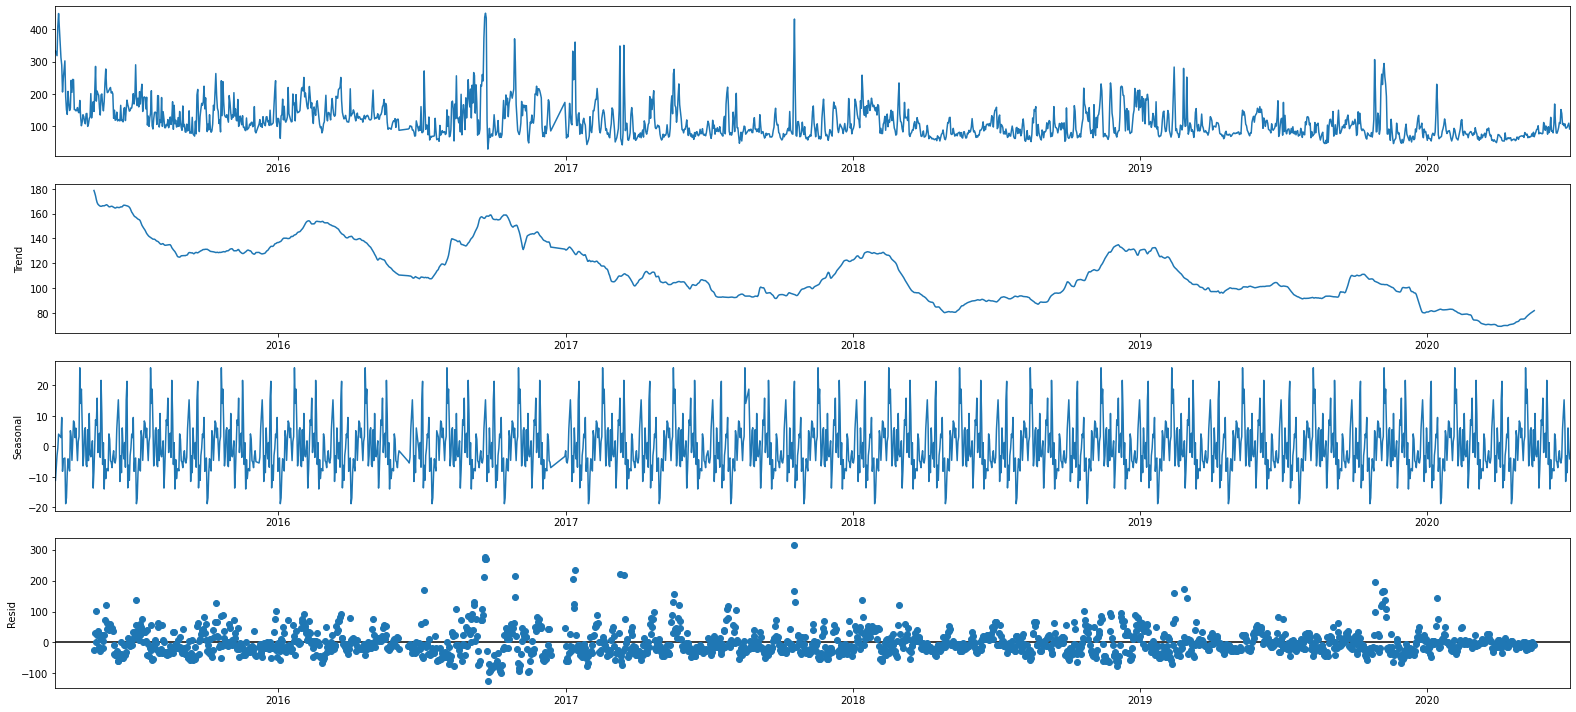

In [ ]:
result = seasonal_decompose(AQI_chen, period = 90)
result.plot()
plt.show()

##Model

In [ ]:
stepwise_fit = auto_arima(AQI_chen['AQI'], m = 7,
                          seasonal = True,
                          trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=18781.194, Time=4.81 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=19115.719, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=19042.071, Time=0.64 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=18998.322, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=19113.739, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=18785.052, Time=3.97 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=18784.421, Time=3.13 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=18782.310, Time=7.25 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=18782.194, Time=7.85 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=18789.542, Time=0.91 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=18782.982, Time=4.78 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=18782.006, Time=5.92 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=18784.174, Time=10.16 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=18779.933, Time=3.00 sec
 ARIMA(1,1,2)(0,0,

                                     SARIMAX Results                                     
Dep. Variable:                               AQI   No. Observations:                 1884
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -9383.456
Date:                           Fri, 07 Oct 2022   AIC                          18776.911
Time:                                   17:55:34   BIC                          18804.615
Sample:                                        0   HQIC                         18787.114
                                          - 1884                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6270      0.012     50.495      0.000       0.603       0.651
ma.L1         -0.9691      0.006   -176.051

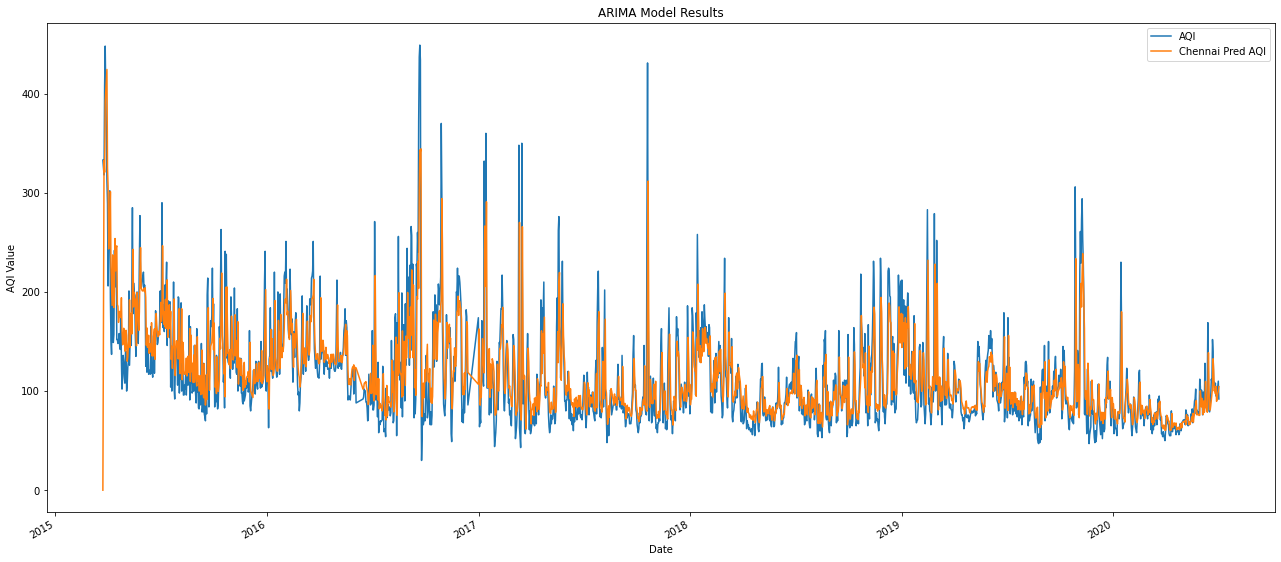

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(AQI_chen, order=(1,1,1), seasonal_order =(1, 0, 1, 7))
chen_ARIMA = model.fit()
print(chen_ARIMA.summary())
Chen_Model_AQI = chen_ARIMA.fittedvalues.rename('Chennai Pred AQI')

AQI_chen.plot(legend=True)
plt.xlabel('Date')
plt.ylabel('AQI Value')
Chen_Model_AQI.plot(legend=True)
plt.title('ARIMA Model Results')
plt.show()

In [ ]:
predictions_ARIMA_diff = pd.Series(chen_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Date
2015-03-24      0.000000
2015-03-26    332.908574
2015-03-27    320.679335
2015-03-28    391.192866
2015-03-31    424.438120
                 ...    
2020-06-27     89.633061
2020-06-28     91.634970
2020-06-29     97.589540
2020-06-30     99.566115
2020-07-01    104.438366
Length: 1884, dtype: float64


In [ ]:
#AQI_chen
# 2015-2018 : 1336
# 2019-2020: 1884-1336
# 2015-2018: 1451

##Test Sample Evaluation

In [ ]:
chen_training = AQI_chen.iloc[:1337]
chen_test = AQI_chen.iloc[1337:1884]
print(chen_training.shape, chen_test.shape)

(1337, 1) (547, 1)


In [ ]:
train_model = SARIMAX(chen_training, order=(1,1,1),seasonal_order =(1, 0, 1, 7))
train_ARIMA = train_model.fit()

start = len(chen_training)
end = len(chen_training)+len(chen_test)-1
chen_pred =chen_ARIMA.predict(start=start, end=end, typ='levels')
chen_pred.index=AQI_chen.index[start:end+1]
chen_pred=chen_pred.rename("Pred AQI")
print(chen_pred)

Date
2019-01-02    177.466556
2019-01-03    149.697392
2019-01-04    157.467292
2019-01-05    169.104829
2019-01-06    122.412049
                 ...    
2020-06-27     89.633061
2020-06-28     91.634970
2020-06-29     97.589540
2020-06-30     99.566115
2020-07-01    104.438366
Name: Pred AQI, Length: 547, dtype: float64


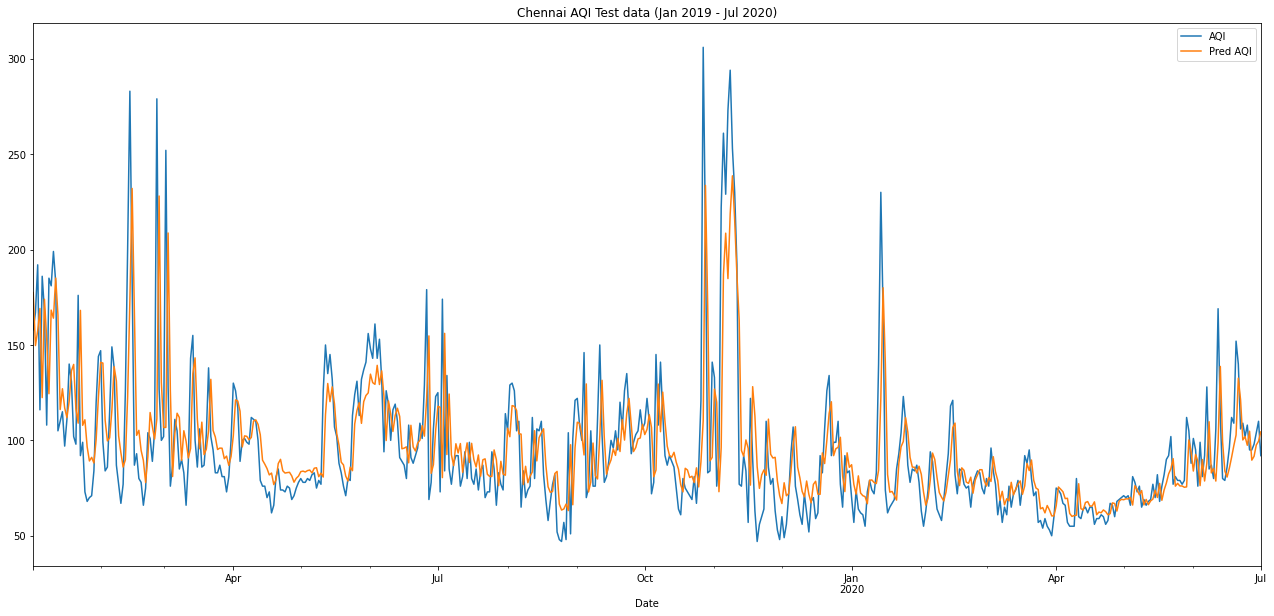

In [ ]:
chen_test['AQI'].plot(legend=True)
pred.plot(legend=True)
plt.title('Chennai AQI Test data (Jan 2019 - Jul 2020)')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
Chennai_corr = np.corrcoef(chen_pred, chen_test.squeeze())[0,1]
Chennai_MAPE = mean_absolute_percentage_error(chen_test.squeeze(),pred)
print("Correlation Coefficient: {}".format(Chennai_corr))
print("Mean Absolute Percentage Error: {}".format(Chennai_MAPE))

Correlation Coefficient: 0.6863928695359476
Mean Absolute Percentage Error: 0.17721838239395854


##AQI future trend prediction for next 1 - Year. 

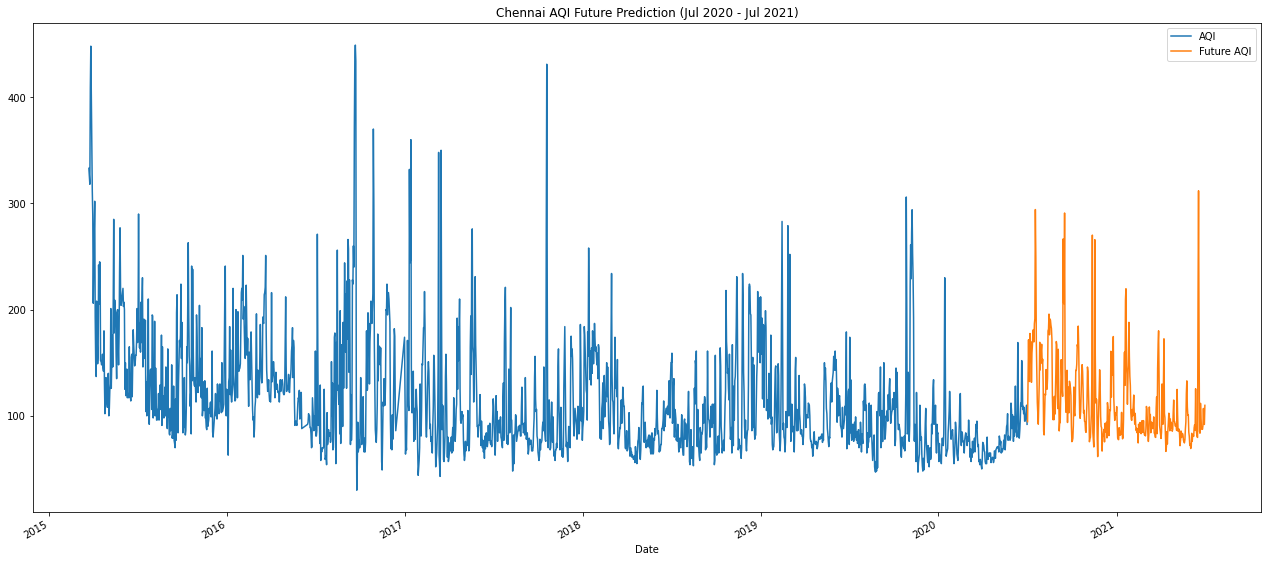

In [ ]:
index_future = pd.date_range(start='2020-07-02', end='2021-07-01')
pred_2 = chen_ARIMA.predict(start=len(chen_test),end = len(chen_test)+364, typ = 'levels')
pred_2.index = index_future
AQI_chen.plot(legend = True)
pred_2 =pred_2.rename("Future AQI")
pred_2.plot(legend = True)
plt.title("Chennai AQI Future Prediction (Jul 2020 - Jul 2021)")
plt.show()


# **Hyderabad**

##Data Processing

In [ ]:
AQI_Hyd = AQI_data.loc[AQI_data['City'] == 'Hyderabad']
AQI_Hyd = AQI_Hyd.drop('City',axis = 1)

In [ ]:
AQI_Hyd = AQI_Hyd.replace(' ',np.nan)
AQI_Hyd = AQI_Hyd.dropna() 
AQI_Hyd


AQI
Date             
2015-03-31  120.0
2015-04-01  112.0
2015-04-06  141.0
2015-04-07  197.0
2015-04-08  177.0
...           ...
2020-06-27   58.0
2020-06-28   49.0
2020-06-29   47.0
2020-06-30   46.0
2020-07-01   48.0

[1880 rows x 1 columns]

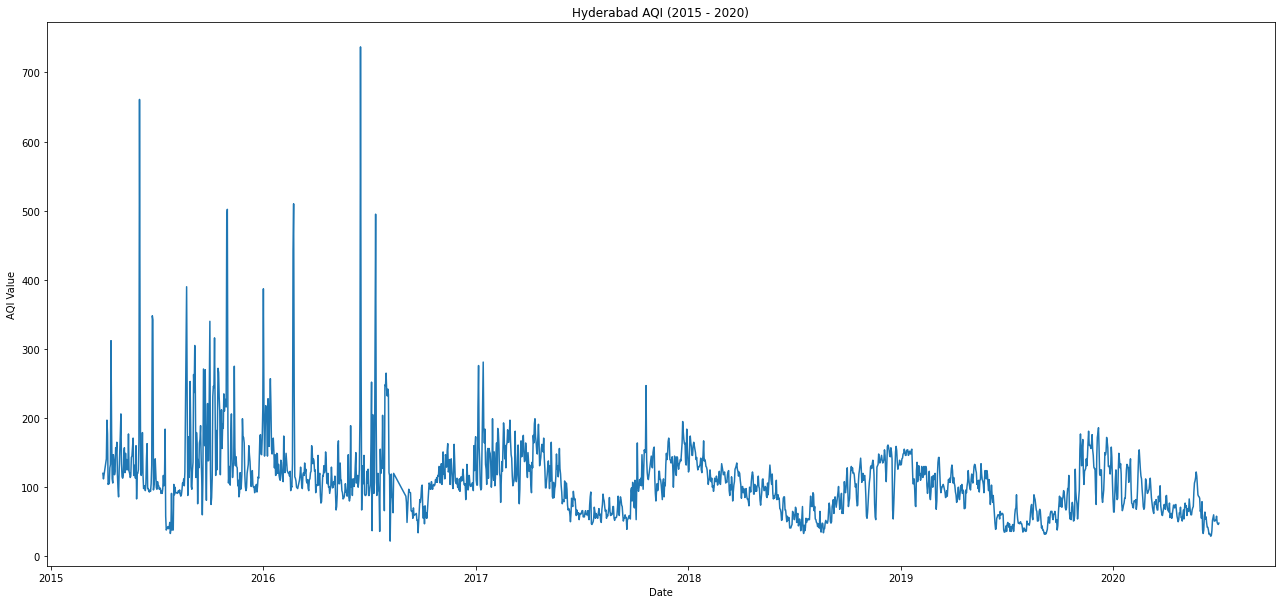

In [ ]:
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.plot(AQI_Hyd)
plt.title("Hyderabad AQI (2015 - 2020)")
plt.show()

##Stationary Check

In [ ]:
#Determine rolling statistics
rolmean = AQI_Hyd.rolling(window=7).mean() 
rolstd = AQI_Hyd.rolling(window=7).std()
print(rolmean,rolstd)


                  AQI
Date                 
2015-03-31        NaN
2015-04-01        NaN
2015-04-06        NaN
2015-04-07        NaN
2015-04-08        NaN
...               ...
2020-06-27  54.285714
2020-06-28  53.285714
2020-06-29  51.428571
2020-06-30  50.714286
2020-07-01  50.285714

[1880 rows x 1 columns]                  AQI
Date                
2015-03-31       NaN
2015-04-01       NaN
2015-04-06       NaN
2015-04-07       NaN
2015-04-08       NaN
...              ...
2020-06-27  3.683942
2020-06-28  4.070802
2020-06-29  3.408672
2020-06-30  3.988077
2020-07-01  4.111540

[1880 rows x 1 columns]


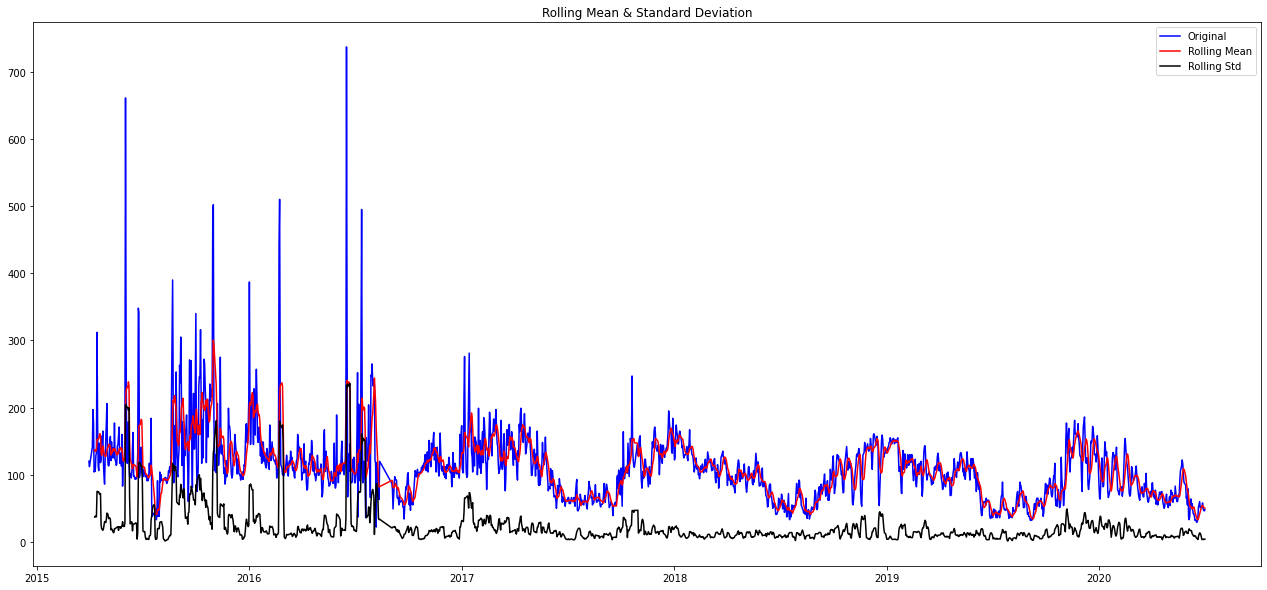

In [ ]:
orig = plt.plot(AQI_Hyd, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(AQI_Hyd['AQI'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -3.561910
p-value                           0.006532
#Lags Used                       24.000000
Number of Observations Used    1855.000000
Critical Value (1%)              -3.433880
Critical Value (5%)              -2.863099
Critical Value (10%)             -2.567600
dtype: float64


##ETS Decomposition

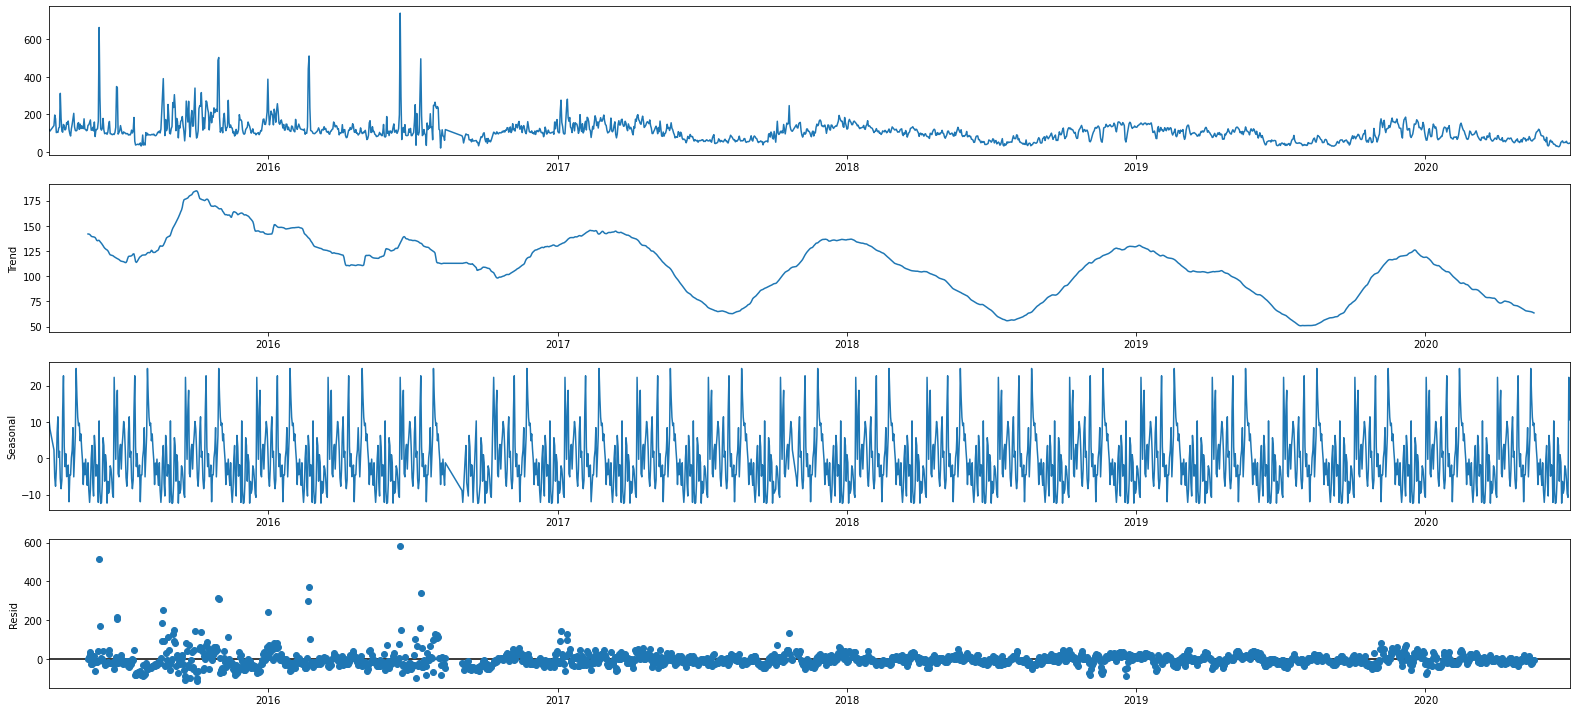

In [ ]:
result = seasonal_decompose(AQI_Hyd, period = 90)
result.plot()
plt.show()

##Model

In [ ]:
stepwise_fit = auto_arima(AQI_Hyd['AQI'], m = 7,
                          seasonal = True,
                          trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=18766.282, Time=4.80 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=19227.905, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=19205.275, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=19153.178, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=19225.907, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=18765.321, Time=2.94 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=18765.668, Time=1.90 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=18765.974, Time=5.45 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=18765.463, Time=2.38 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=18763.762, Time=8.74 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=18760.197, Time=9.88 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=18762.962, Time=5.83 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=18758.655, Time=8.67 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=18762.358, Time=5.52 sec
 ARIMA(1,1,2)(2,0,1

                                       SARIMAX Results                                        
Dep. Variable:                                    AQI   No. Observations:                 1880
Model:             SARIMAX(0, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -9370.367
Date:                                Fri, 07 Oct 2022   AIC                          18756.734
Time:                                        18:51:44   BIC                          18801.042
Sample:                                             0   HQIC                         18773.054
                                               - 1880                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3235      0.007    -47.566      0.000      -0.337      -0.310
ma.

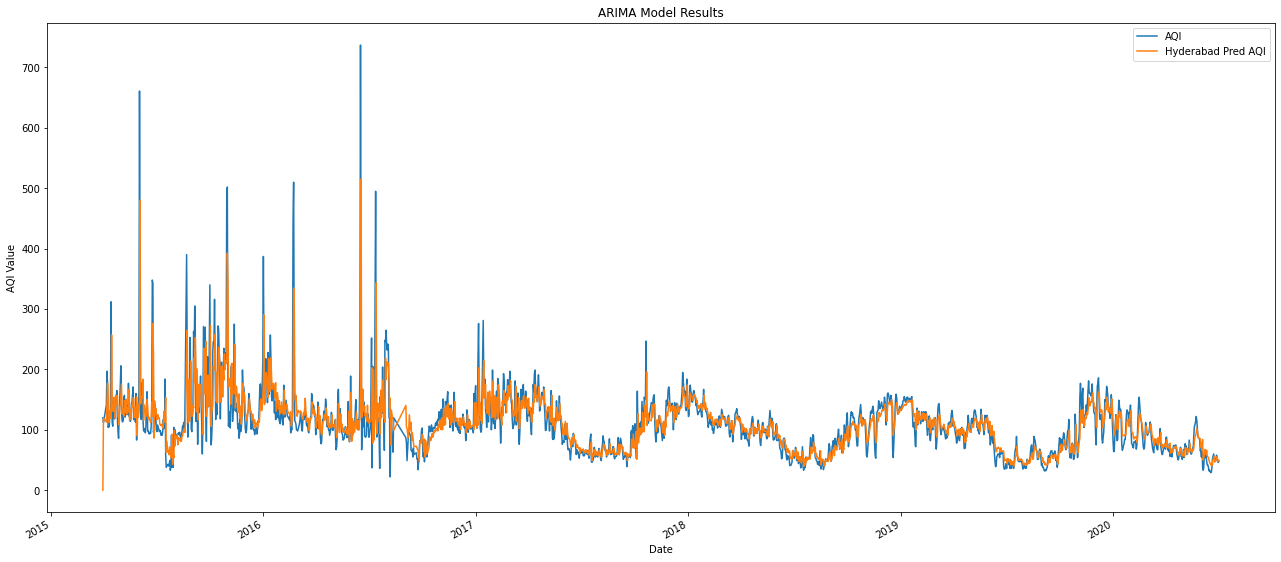

In [ ]:
model = SARIMAX(AQI_Hyd, order=(0,1,3), seasonal_order =(2, 0, 2, 7))
Hyd_ARIMA = model.fit()

print(Hyd_ARIMA.summary())
Hyd_Model_AQI = Hyd_ARIMA.fittedvalues.rename('Hyderabad Pred AQI')

AQI_Hyd.plot(legend=True)
plt.xlabel('Date')
plt.ylabel('AQI Value')
Hyd_Model_AQI.plot(legend=True)
plt.title('ARIMA Model Results')
plt.show()


In [ ]:
predictions_ARIMA_diff = pd.Series(Hyd_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Date
2015-03-31      0.000000
2015-04-01    119.977952
2015-04-06    112.841823
2015-04-07    139.188855
2015-04-08    177.008987
                 ...    
2020-06-27     51.512839
2020-06-28     55.606247
2020-06-29     47.681610
2020-06-30     49.730149
2020-07-01     49.271066
Length: 1880, dtype: float64


##Test Sample Evaluation

In [ ]:
#AQI_Hyd.index[:1332]
# 2015-2019 : 1332
# 2015-2020: 1880
# 2015-2018: 1451

In [ ]:
Hyd_training = AQI_Hyd.iloc[:1332]
Hyd_test = AQI_Hyd.iloc[1333:1880]
print(Hyd_training.shape, Hyd_test.shape)

(1332, 1) (547, 1)


In [ ]:
train_model = SARIMAX(Hyd_training, order=(0,1,3),seasonal_order =(2, 0, 2, 7))
train_ARIMA = train_model.fit()

In [ ]:
start = len(Hyd_training)
end = len(Hyd_training)+len(Hyd_test)-1
pred = Hyd_ARIMA.predict(start=start, end=end, typ='levels')
pred.index=AQI_Hyd.index[start:end+1]
pred=pred.rename("Pred AQI")
print(pred)

Date
2019-01-01    132.901976
2019-01-02    133.399458
2019-01-03    133.620524
2019-01-04    138.443254
2019-01-05    137.791142
                 ...    
2020-06-26     50.156970
2020-06-27     51.512839
2020-06-28     55.606247
2020-06-29     47.681610
2020-06-30     49.730149
Name: Pred AQI, Length: 547, dtype: float64


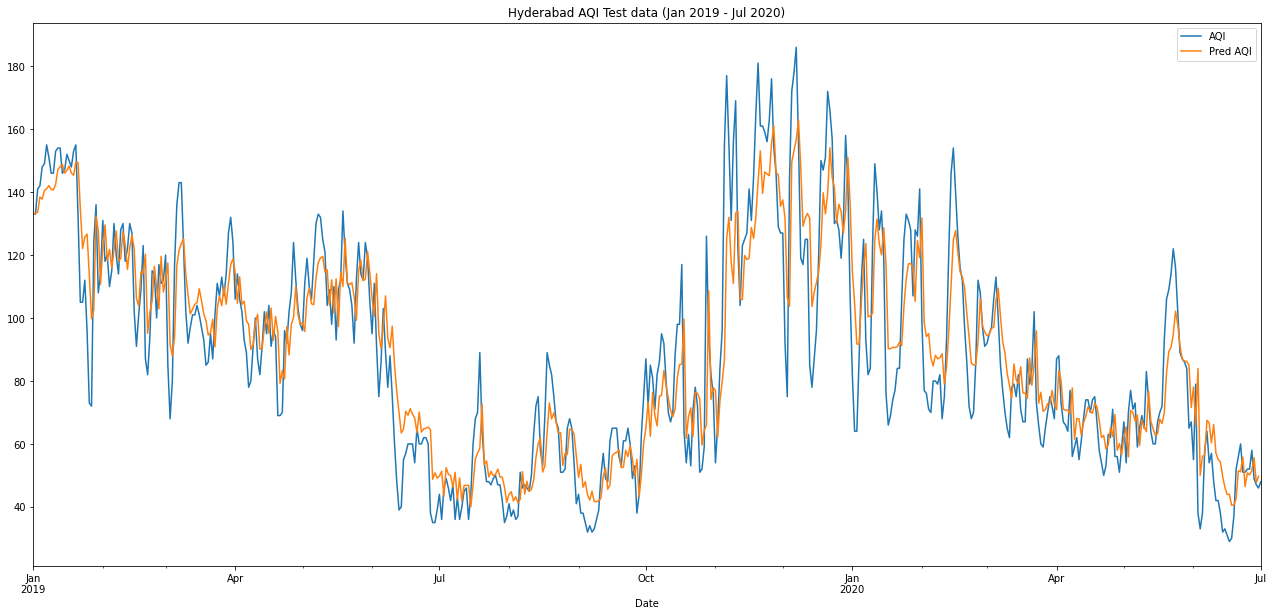

In [ ]:
Hyd_test['AQI'].plot(legend=True)
pred.plot(legend=True)
plt.title('Hyderabad AQI Test data (Jan 2019 - Jul 2020)')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
Hyd_corr = np.corrcoef(pred, Hyd_test.squeeze())[0,1]
Hyd_MAPE = mean_absolute_percentage_error(Hyd_test.squeeze(),pred)
print("Correlation Coefficient: {}".format(Hyd_corr))
print("Mean Absolute Percentage Error: {}".format(Hyd_MAPE))

Correlation Coefficient: 0.8360181013012807
Mean Absolute Percentage Error: 0.1797228206679549


##AQI future trend prediction for next 1 - Year. 

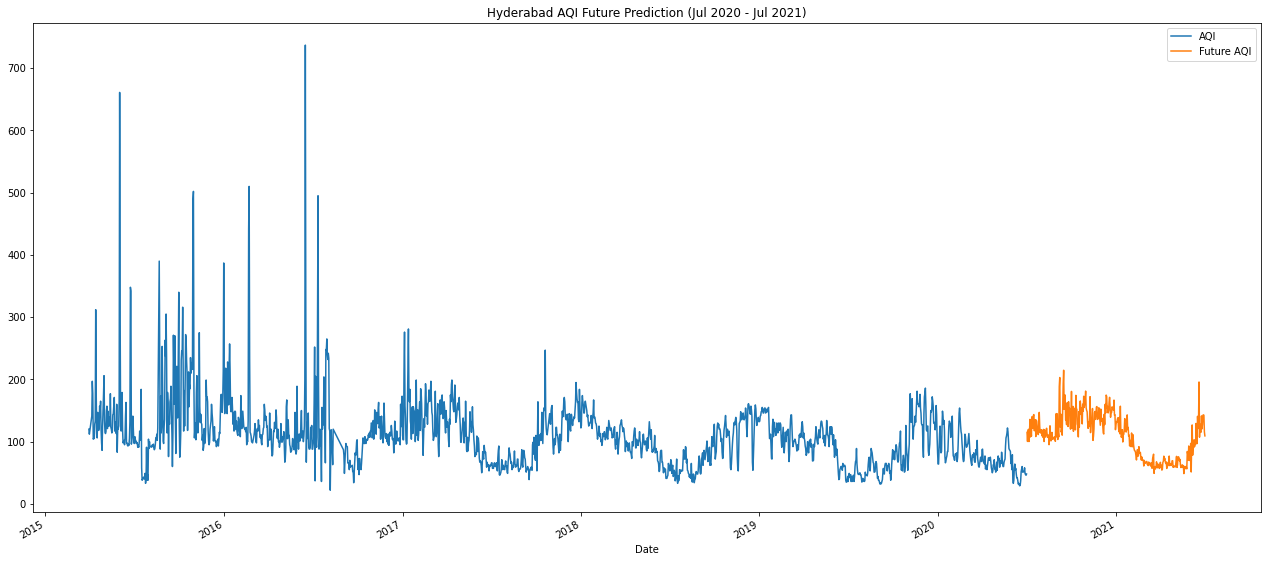

In [ ]:
index_future = pd.date_range(start='2020-07-02', end='2021-07-01')
pred_2 = Hyd_ARIMA.predict(start=len(Hyd_test),end = len(Hyd_test)+364, typ = 'levels')
pred_2.index = index_future

AQI_Hyd.plot(legend = True)
pred_2 =pred_2.rename("Future AQI")
pred_2.plot(legend = True)
plt.title("Hyderabad AQI Future Prediction (Jul 2020 - Jul 2021)")
plt.show()

# **Lucknow**

##Data Processing

In [ ]:
AQI_Luc = AQI_data.loc[AQI_data['City'] == 'Lucknow']
AQI_Luc = AQI_Luc.drop('City',axis = 1)

In [ ]:
AQI_Luc = AQI_Luc.replace(' ',np.nan)
AQI_Luc = AQI_Luc.dropna() 
AQI_Luc

AQI
Date             
2015-03-21  607.0
2015-03-22  707.0
2015-03-23  699.0
2015-03-24  108.0
2015-03-25  111.0
...           ...
2020-06-27   74.0
2020-06-28   77.0
2020-06-29   65.0
2020-06-30   69.0
2020-07-01   76.0

[1893 rows x 1 columns]

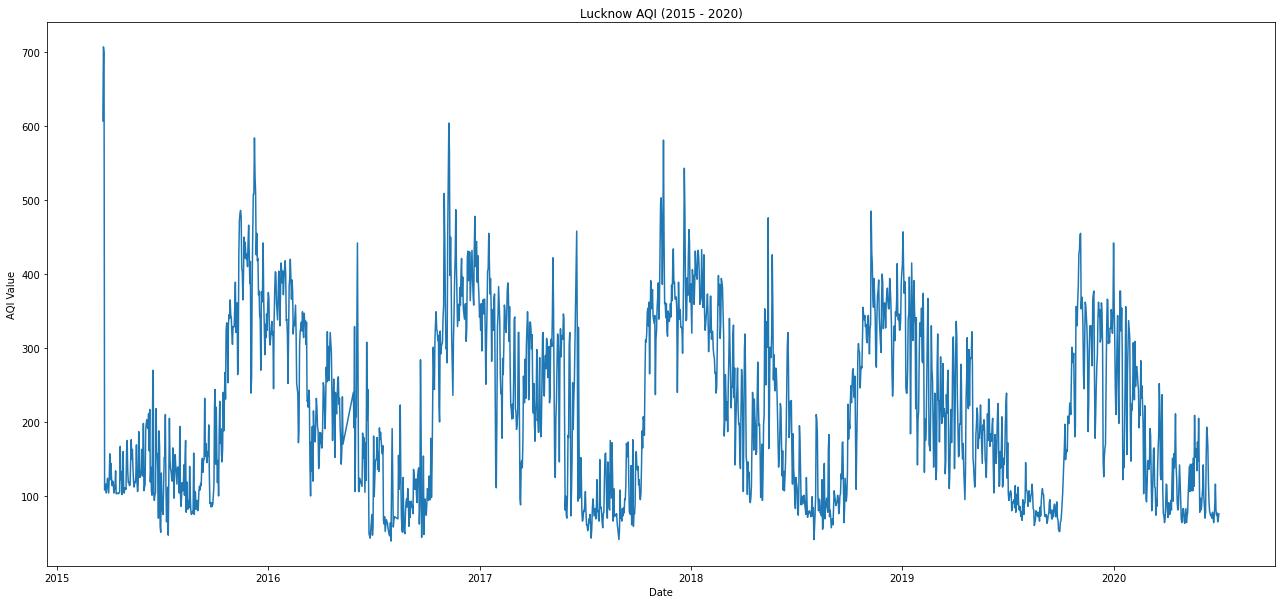

In [ ]:
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.plot(AQI_Luc)
plt.title("Lucknow AQI (2015 - 2020)")
plt.show()

##Stationarity Check

In [ ]:
#Determine rolling statistics
rolmean = AQI_Luc.rolling(window=7).mean() 
rolstd = AQI_Luc.rolling(window=7).std()
print(rolmean,rolstd)


                  AQI
Date                 
2015-03-21        NaN
2015-03-22        NaN
2015-03-23        NaN
2015-03-24        NaN
2015-03-25        NaN
...               ...
2020-06-27  81.142857
2020-06-28  82.000000
2020-06-29  82.142857
2020-06-30  81.714286
2020-07-01  79.714286

[1893 rows x 1 columns]                   AQI
Date                 
2015-03-21        NaN
2015-03-22        NaN
2015-03-23        NaN
2015-03-24        NaN
2015-03-25        NaN
...               ...
2020-06-27  17.439692
2020-06-28  17.000000
2020-06-29  16.826849
2020-06-30  17.163083
2020-07-01  16.849474

[1893 rows x 1 columns]


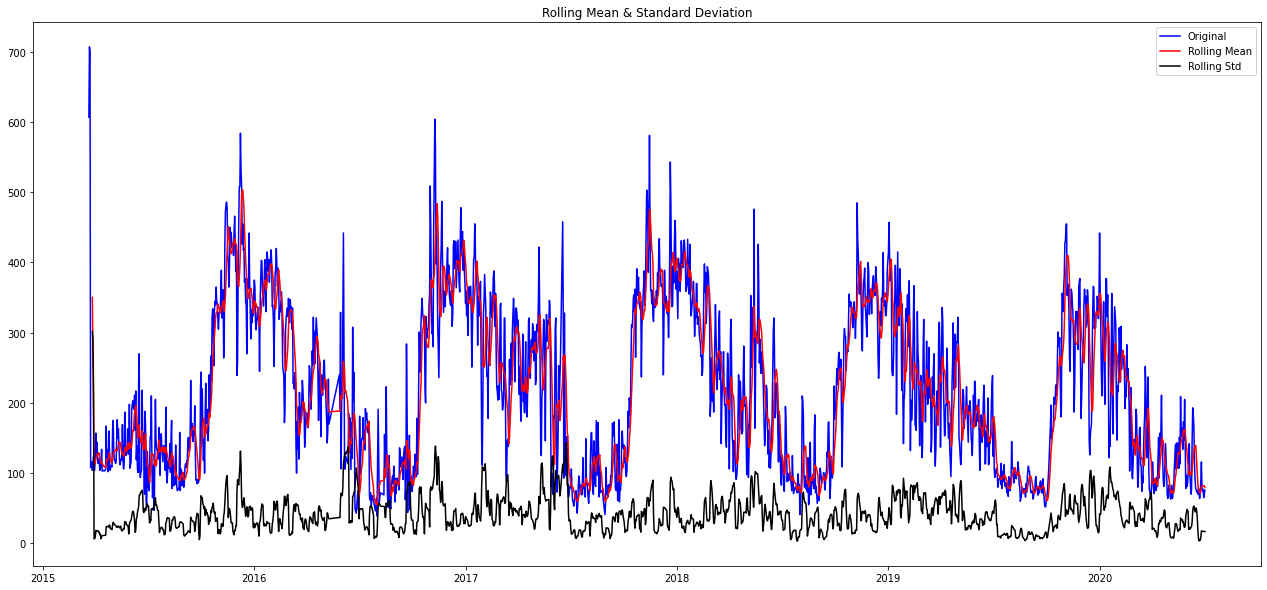

In [ ]:
orig = plt.plot(AQI_Luc, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(AQI_Luc['AQI'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -3.606502
p-value                           0.005638
#Lags Used                       10.000000
Number of Observations Used    1882.000000
Critical Value (1%)              -3.433829
Critical Value (5%)              -2.863077
Critical Value (10%)             -2.567588
dtype: float64


##ETS Decomposition

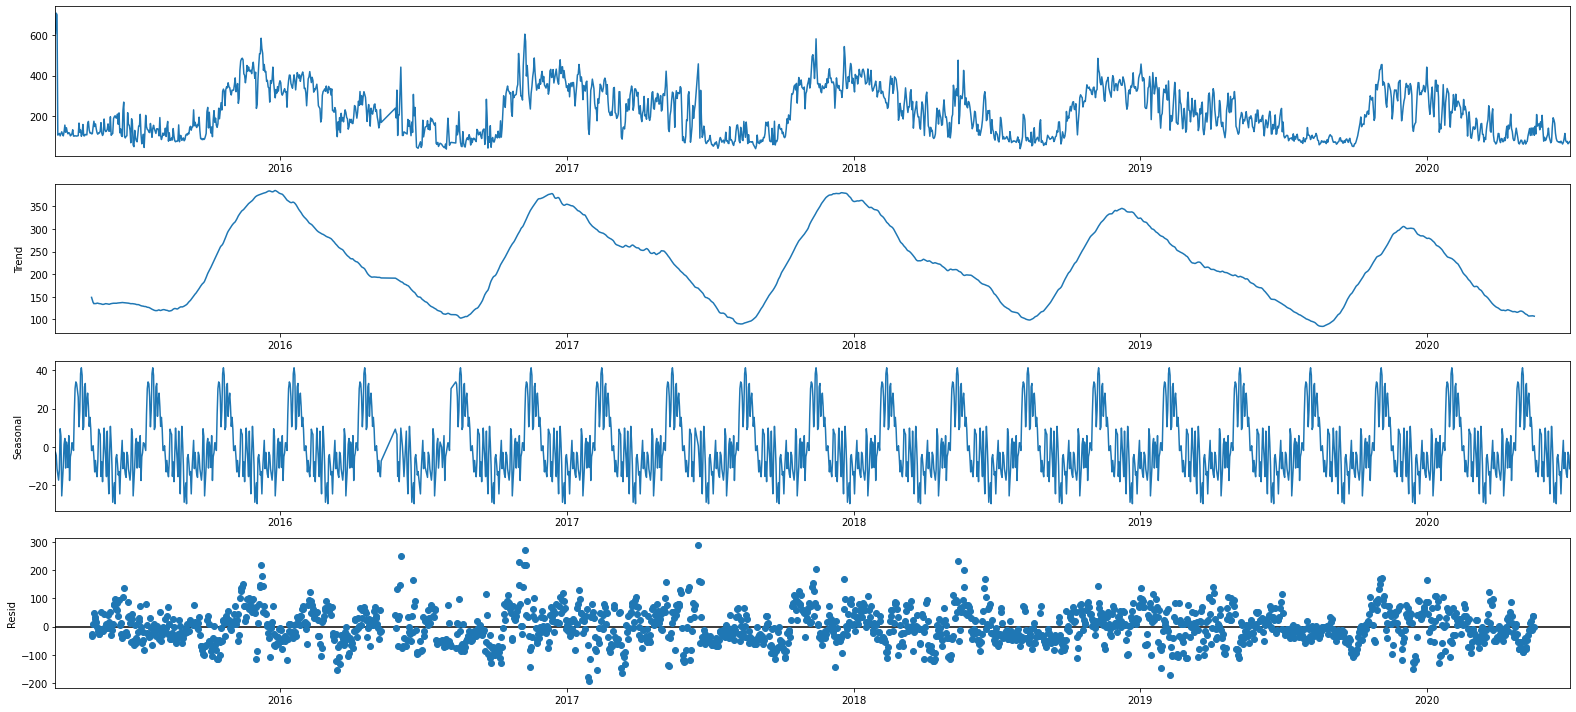

In [ ]:
result = seasonal_decompose(AQI_Luc, period = 90)
result.plot()
plt.show()

##Model

In [ ]:
stepwise_fit = auto_arima(AQI_Luc['AQI'], m = 7,
                          seasonal = True,
                          trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=20042.303, Time=4.73 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=20257.717, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=20244.317, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=20233.076, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=20255.774, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=20040.915, Time=3.48 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=20040.390, Time=1.05 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=20040.890, Time=2.84 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=20040.986, Time=0.73 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=20040.711, Time=0.90 sec
 ARIMA(3,1,2)(0,0,0)[7] intercept   : AIC=20037.236, Time=1.47 sec
 ARIMA(3,1,2)(1,0,0)[7] intercept   : AIC=20038.664, Time=3.01 sec
 ARIMA(3,1,2)(0,0,1)[7] intercept   : AIC=20038.673, Time=3.49 sec
 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=20040.189, Time=5.41 sec
 ARIMA(3,1,1)(0,0,0

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                 1893
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -10009.211
Date:                Fri, 07 Oct 2022   AIC                          20032.422
Time:                        19:07:08   BIC                          20071.239
Sample:                             0   HQIC                         20046.715
                               - 1893                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1144      0.106     -1.080      0.280      -0.322       0.093
ar.L2          0.3530      0.082      4.289      0.000       0.192       0.514
ar.L3         -0.0741      0.029     -2.548      0.0

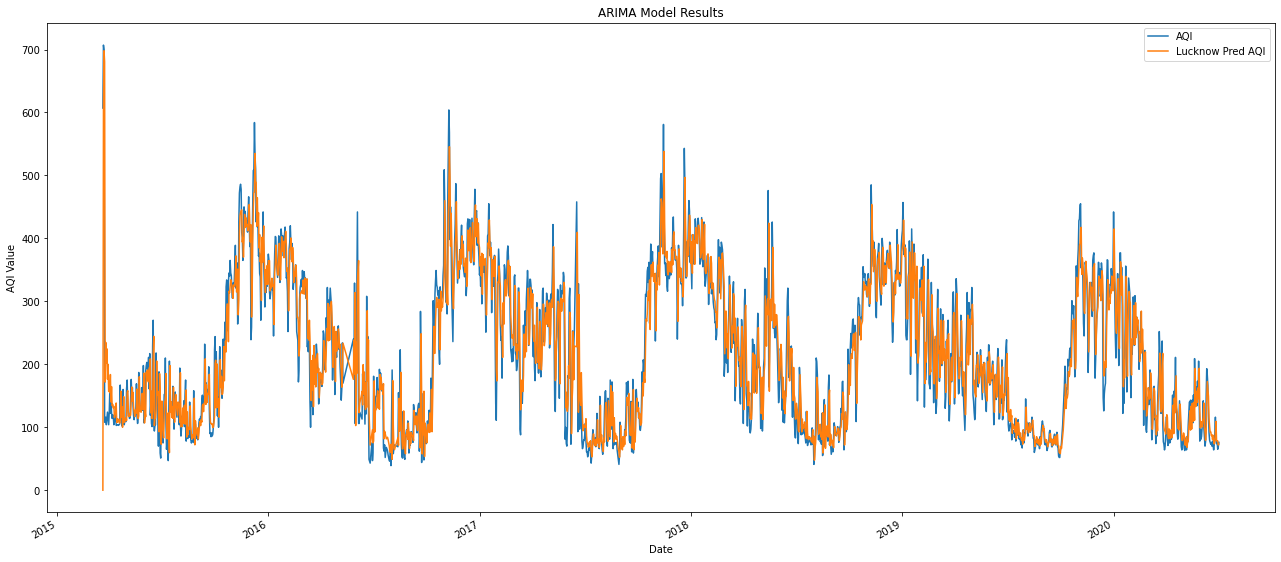

In [ ]:
model = ARIMA(AQI_Luc, order=(4,1,2))
Luc_ARIMA = model.fit()
print(Luc_ARIMA.summary())
Luc_Model_AQI = Luc_ARIMA.fittedvalues.rename('Lucknow Pred AQI')

AQI_Luc.plot(legend=True)
plt.xlabel('Date')
plt.ylabel('AQI Value')
Luc_Model_AQI.plot(legend=True)
plt.title('ARIMA Model Results')
plt.show()

In [ ]:
predictions_ARIMA_diff = pd.Series(Luc_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Date
2015-03-21      0.000000
2015-03-22    606.862632
2015-03-23    698.045556
2015-03-24    680.626080
2015-03-25    171.685705
                 ...    
2020-06-27     78.990822
2020-06-28     77.895532
2020-06-29     78.335231
2020-06-30     71.860894
2020-07-01     73.305441
Length: 1893, dtype: float64


##Test Sample Evaluation

In [ ]:
#AQI_Luc.index[:1345]

In [ ]:
Luc_training = AQI_Luc.iloc[:1345]
Luc_test = AQI_Luc.iloc[1346:1893]
print(Luc_training.shape, Luc_test.shape)

(1345, 1) (547, 1)


In [ ]:
train_model = ARIMA(Luc_training, order=(4,1,2))
train_ARIMA = train_model.fit()

In [ ]:
start = len(Luc_training)
end = len(Luc_training)+len(Luc_test)-1
pred = Luc_ARIMA.predict(start=start, end=end, typ='levels')
pred.index=AQI_Luc.index[start:end+1]
pred=pred.rename("Pred AQI")
print(pred)

Date
2019-01-01    385.960382
2019-01-02    394.920394
2019-01-03    429.031651
2019-01-04    390.904340
2019-01-05    371.104702
                 ...    
2020-06-26    109.382530
2020-06-27     78.990822
2020-06-28     77.895532
2020-06-29     78.335231
2020-06-30     71.860894
Name: Pred AQI, Length: 547, dtype: float64


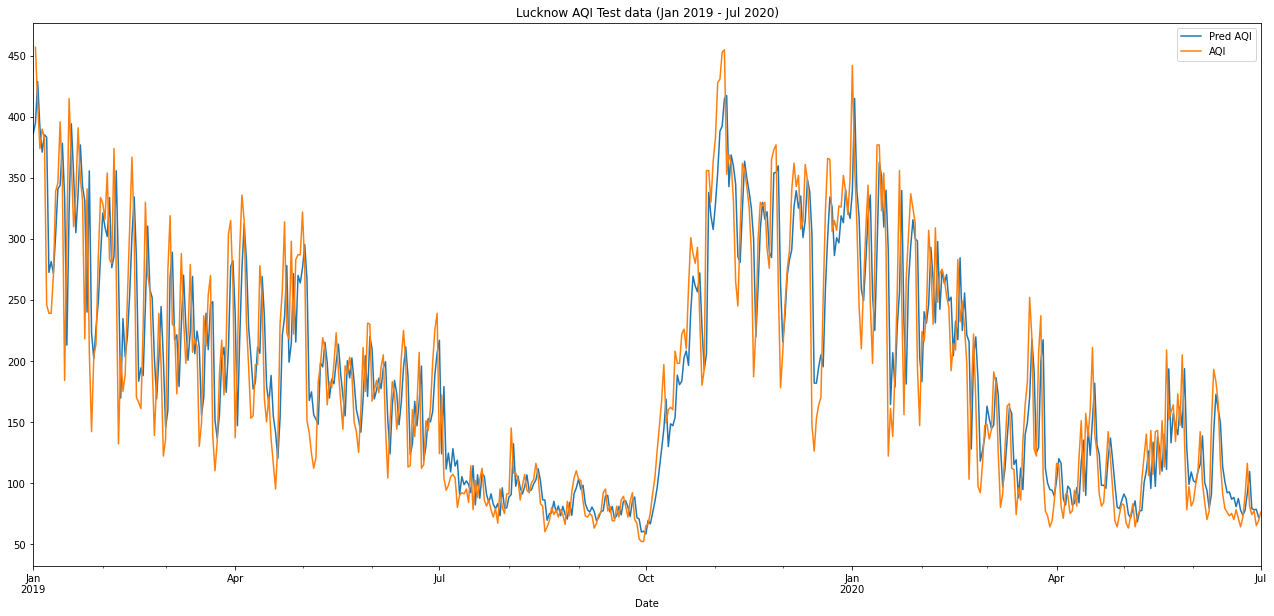

In [ ]:
pred.plot(legend=True)
Luc_test['AQI'].plot(legend=True)
plt.title('Lucknow AQI Test data (Jan 2019 - Jul 2020)')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
Luc_corr = np.corrcoef(pred, Luc_test.squeeze())[0,1]
Luc_MAPE = mean_absolute_percentage_error(Luc_test.squeeze(),pred)
print("Correlation Coefficient: {}".format(Luc_corr))
print("Mean Absolute Percentage Error: {}".format(Luc_MAPE))

Correlation Coefficient: 0.8016515119422738
Mean Absolute Percentage Error: 0.25478843044584154


##AQI future trend prediction for next 1 - Year. 

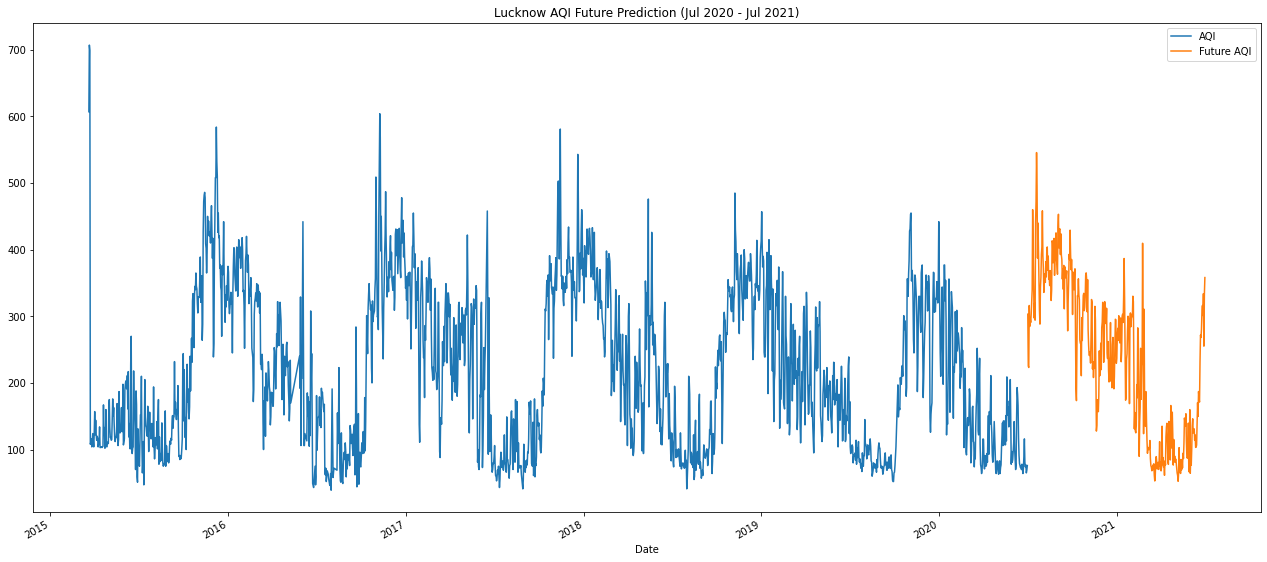

In [ ]:
index_future = pd.date_range(start='2020-07-02', end='2021-07-01')
pred_2 = Luc_ARIMA.predict(start=len(Luc_test),end = len(Luc_test)+364, typ = 'levels')
pred_2.index = index_future

AQI_Luc.plot(legend = True)
pred_2 =pred_2.rename("Future AQI")
pred_2.plot(legend = True)
plt.title("Lucknow AQI Future Prediction (Jul 2020 - Jul 2021)")
plt.show()


# **Bengaluru**


##Data Processing

In [ ]:
AQI_Ben = AQI_data.loc[AQI_data['City'] == 'Bengaluru']
AQI_Ben = AQI_Ben.drop('City',axis = 1)

In [ ]:
AQI_Ben = AQI_Ben.replace(' ',np.nan)
AQI_Ben = AQI_Ben.dropna() 
AQI_Ben

AQI
Date             
2015-03-21   91.0
2015-03-22  120.0
2015-03-23  154.0
2015-03-24  119.0
2015-03-25  232.0
...           ...
2020-06-27   51.0
2020-06-28   61.0
2020-06-29   65.0
2020-06-30   63.0
2020-07-01   43.0

[1910 rows x 1 columns]

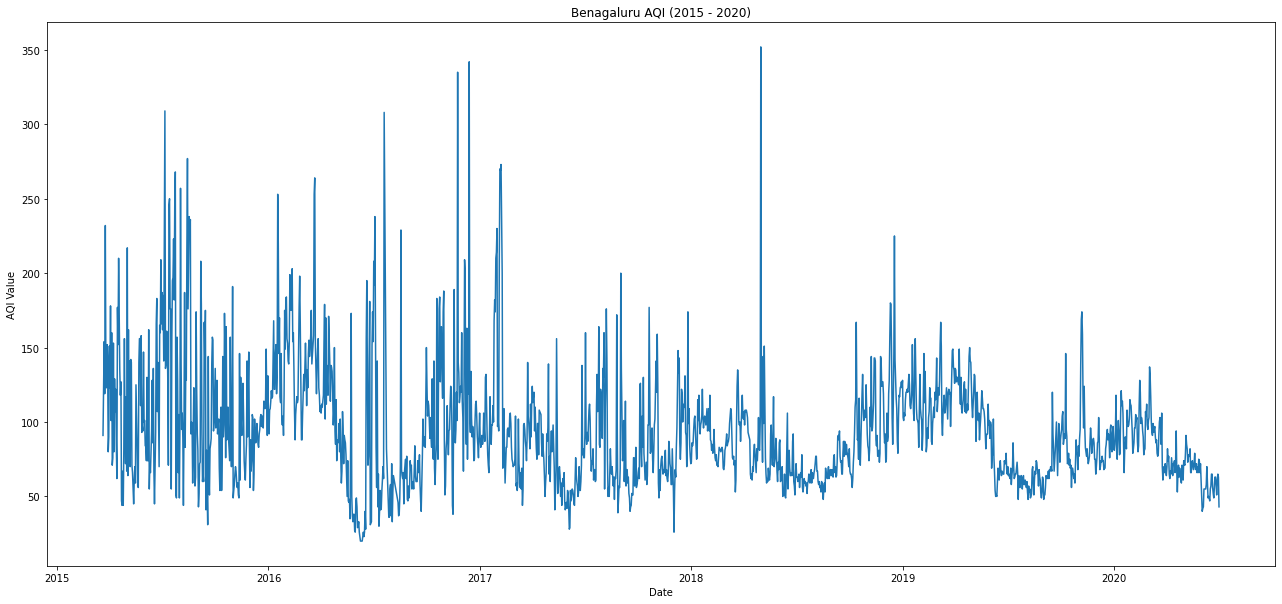

In [ ]:
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.plot(AQI_Ben)
plt.title("Benagaluru AQI (2015 - 2020)")
plt.show()

## Stationarity Check

In [ ]:
rolmean = AQI_Ben.rolling(window=7).mean() 
rolstd = AQI_Ben.rolling(window=7).std()
print(rolmean,rolstd)

                  AQI
Date                 
2015-03-21        NaN
2015-03-22        NaN
2015-03-23        NaN
2015-03-24        NaN
2015-03-25        NaN
...               ...
2020-06-27  56.000000
2020-06-28  57.285714
2020-06-29  59.571429
2020-06-30  60.571429
2020-07-01  57.714286

[1910 rows x 1 columns]                  AQI
Date                
2015-03-21       NaN
2015-03-22       NaN
2015-03-23       NaN
2015-03-24       NaN
2015-03-25       NaN
...              ...
2020-06-27  5.656854
2020-06-28  5.618846
2020-06-29  4.894117
2020-06-30  4.755949
2020-07-01  7.973169

[1910 rows x 1 columns]


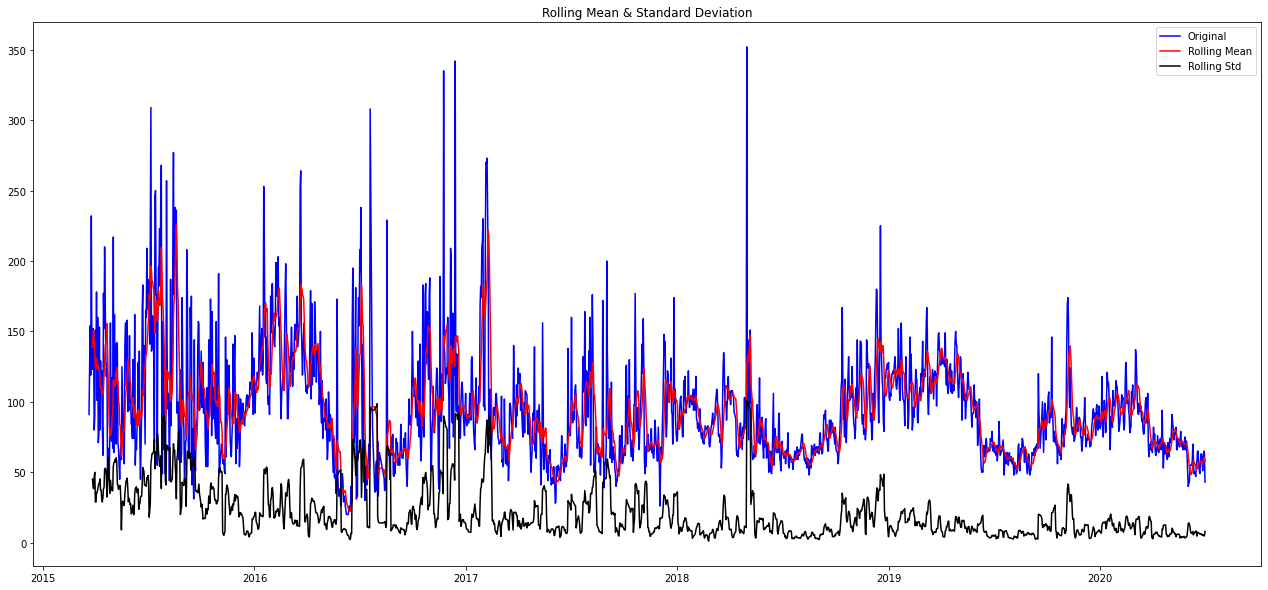

In [ ]:
orig = plt.plot(AQI_Ben, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(AQI_Ben['AQI'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)


Results of Dickey Fuller Test:
Test Statistic                -6.077778e+00
p-value                        1.110857e-07
#Lags Used                     1.200000e+01
Number of Observations Used    1.897000e+03
Critical Value (1%)           -3.433802e+00
Critical Value (5%)           -2.863065e+00
Critical Value (10%)          -2.567582e+00
dtype: float64


##ETS Decomposition

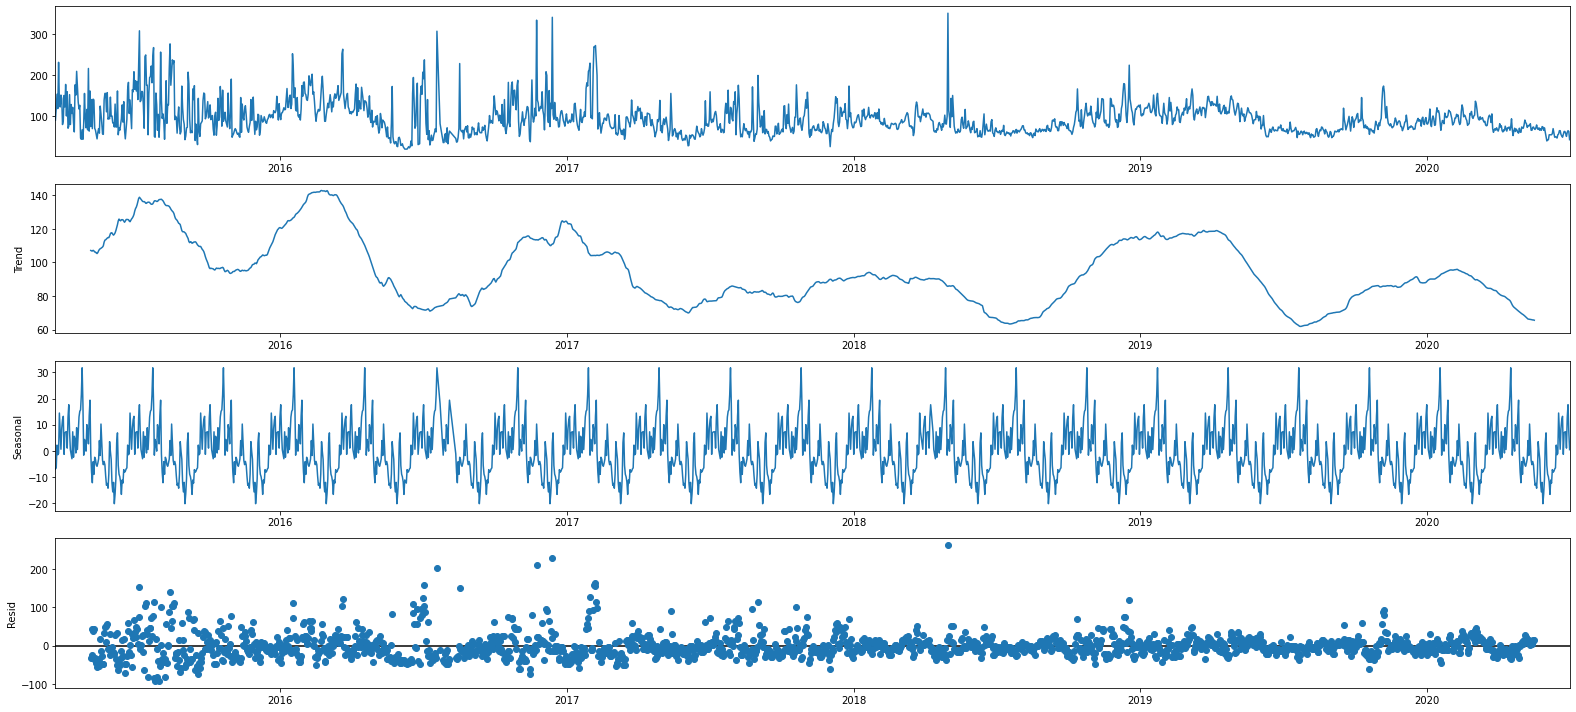

In [ ]:
result = seasonal_decompose(AQI_Ben, period = 90)
result.plot()
plt.show()

##Model

In [ ]:
import statsmodels.compat.numpy
from pmdarima import auto_arima
stepwise_fit = auto_arima(AQI_Ben['AQI'], m = 7,
                          seasonal = True,
                          trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=18386.464, Time=5.05 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=18890.983, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=18717.878, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=18541.705, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=18888.984, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=18386.519, Time=2.07 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=18386.715, Time=1.77 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=18387.366, Time=12.88 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=18388.251, Time=11.89 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=18389.521, Time=0.86 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=18388.129, Time=4.51 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=18384.650, Time=7.01 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=18385.659, Time=3.29 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=18385.743, Time=3.21 sec
 ARIMA(3,1,2)(2,0

                                     SARIMAX Results                                     
Dep. Variable:                               AQI   No. Observations:                 1910
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 7)   Log Likelihood               -9186.503
Date:                           Fri, 07 Oct 2022   AIC                          18381.005
Time:                                   19:33:52   BIC                          18403.222
Sample:                                        0   HQIC                         18389.182
                                          - 1910                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4255      0.015     29.150      0.000       0.397       0.454
ma.L1         -0.9271      0.008   -116.297

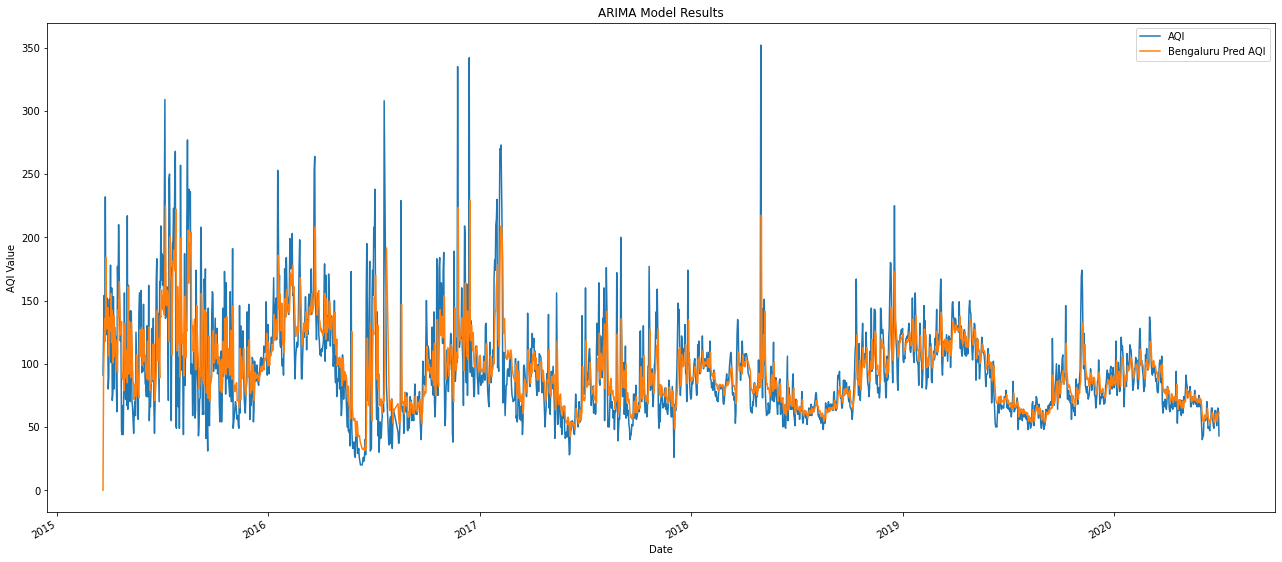

In [ ]:
model = SARIMAX(AQI_Ben, order=(1,1,1),seasonal_order =(0, 0, 1, 7))
Ben_ARIMA = model.fit()
print(Ben_ARIMA.summary())
Ben_Model_AQI = Ben_ARIMA.fittedvalues.rename('Bengaluru Pred AQI')

AQI_Ben.plot(legend=True)
plt.xlabel('Date')
plt.ylabel('AQI Value')
Ben_Model_AQI.plot(legend=True)
plt.title('ARIMA Model Results')
plt.show()


In [ ]:
predictions_ARIMA_diff = pd.Series(Ben_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Date
2015-03-21      0.000000
2015-03-22     90.970046
2015-03-23    111.740423
2015-03-24    135.833880
2015-03-25    117.706243
                 ...    
2020-06-27     57.807542
2020-06-28     54.327606
2020-06-29     59.004655
2020-06-30     61.559788
2020-07-01     61.033426
Length: 1910, dtype: float64


## Test Sample Evaluation

In [ ]:
#AQI_Ben.index[:1362]
# 2015-2018 : 1362
# 2019-2020: 1910-1336
# 2015-2018: 1451

In [ ]:
Ben_training = AQI_Ben.iloc[:1362]
Ben_test = AQI_Ben.iloc[1363:1910]
print(Ben_training.shape, Ben_test.shape)

(1362, 1) (547, 1)


In [ ]:
train_model = SARIMAX(Ben_training, order=(1,1,1),seasonal_order =(0, 0, 1, 7))
train_ARIMA = train_model.fit()

In [ ]:
start = len(Ben_training)
end = len(Ben_training)+len(Ben_test)-1
pred = Ben_ARIMA.predict(start=start, end=end, typ='levels')
pred.index=AQI_Ben.index[start:end+1]
pred=pred.rename("Pred AQI")
print(pred)

Date
2019-01-01    120.915870
2019-01-02    124.143229
2019-01-03    111.500494
2019-01-04    110.245765
2019-01-05    111.983755
                 ...    
2020-06-26     60.620810
2020-06-27     57.807542
2020-06-28     54.327606
2020-06-29     59.004655
2020-06-30     61.559788
Name: Pred AQI, Length: 547, dtype: float64


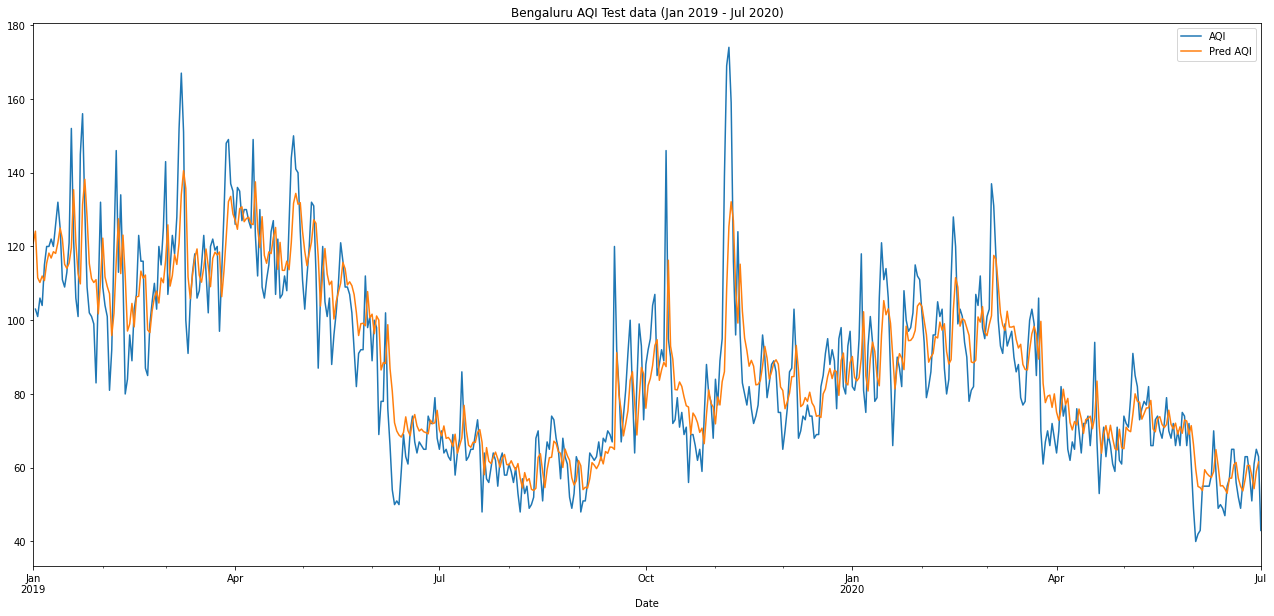

In [ ]:
Ben_test['AQI'].plot(legend=True)
pred.plot(legend=True)
plt.title('Bengaluru AQI Test data (Jan 2019 - Jul 2020)')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
Ben_corr = np.corrcoef(pred, Ben_test.squeeze())[0,1]
Ben_MAPE = mean_absolute_percentage_error(Ben_test.squeeze(),pred)
print("Correlation Coefficient: {}".format(Ben_corr))
print("Mean Absolute Percentage Error: {}".format(Ben_MAPE))

Correlation Coefficient: 0.8079755028185557
Mean Absolute Percentage Error: 0.12614174872175593


##AQI future trend prediction for next 1 - Year. 

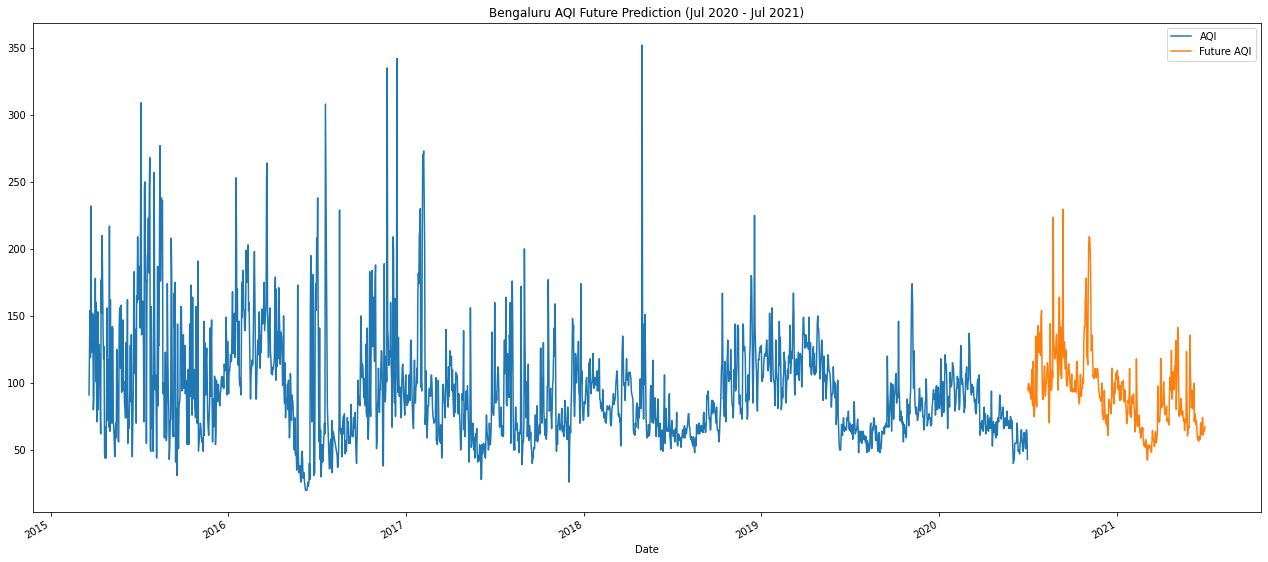

In [ ]:
index_future = pd.date_range(start='2020-07-02', end='2021-07-01')
pred_2 = Ben_ARIMA.predict(start=len(Ben_test),end = len(Ben_test)+364, typ = 'levels')
pred_2.index = index_future

AQI_Ben.plot(legend = True)
pred_2 =pred_2.rename("Future AQI")
pred_2.plot(legend = True)
plt.title("Bengaluru AQI Future Prediction (Jul 2020 - Jul 2021)")
plt.show()
